# Complete Guide to Nirs4all Library Usage

<img src="../docs/nirs4all_logo.png" width="300" alt="NIRS4ALL Logo">

## What is Near-Infrared Spectroscopy (NIRS)?

Near-Infrared Spectroscopy (NIRS) is a rapid and non-destructive analytical technique that uses the near-infrared region of the electromagnetic spectrum (approximately 700-2500 nm). NIRS measures how near-infrared light interacts with the molecular bonds in materials, particularly C-H, N-H, and O-H bonds, providing information about the chemical composition of samples.

### Key advantages of NIRS:
- Non-destructive analysis
- Minimal sample preparation
- Rapid results (seconds to minutes)
- Potential for on-line/in-line implementation
- Simultaneous measurement of multiple parameters

### Common applications:
- Agriculture: soil analysis, crop quality assessment
- Food industry: quality control, authenticity verification
- Pharmaceutical: raw material verification, process monitoring
- Medical: tissue monitoring, brain imaging
- Environmental: pollutant detection, water quality monitoring

## The nirs4all Framework

Nirs4all is a comprehensive machine learning library specifically designed for NIRS data analysis. It bridges the gap between spectroscopic data and machine learning by providing tools for:

<img src="../docs/pipeline.jpg" width="700" alt="NIRS4ALL Pipeline">

This notebook provides a comprehensive guide to using the nirs4all library for machine learning pipelines, from simple data loading and visualization to complex model training, fine-tuning, and custom transformations.

## 📑 Table of Contents

<!-- Note: These are clickable links that navigate within the notebook -->

1. [Introduction and Setup](#1-setup-and-imports) 🔰
2. [Data Loading and Exploration](#2-data-loading-and-exploration) 🔰
3. [Basic Processing Pipeline](#3-basic-processing-pipeline) 🔰
4. [Training scikit-learn Models](#4-training-scikit-learn-models) 🔰
5. [Training TensorFlow Models](#5-training-tensorflow-models) 🔰 🔶
6. [Fine-tuning Models](#6-fine-tuning-models) 🔶
7. [Advanced Pipeline with Custom Transformations](#7-advanced-pipeline-with-custom-transformations) 🔶 🔺
8. [Running Multiple Configurations in Parallel](#8-running-multiple-configurations-in-parallel) 🔶
9. [Advanced Data Visualization](#9-advanced-data-visualization) 🔰
10. [Transformation Effects Visualization](#10-transformation-effects-visualization) 🔰 
11. [Model Performance Analysis](#11-model-performance-analysis) 🔶
12. [Feature Importance Analysis](#12-feature-importance-analysis) 🔶
13. [Prediction Visualization](#13-prediction-visualization) 🔰
14. [Classification Metrics](#14-classification-metrics) 🔰
15. [Residual Analysis](#15-residual-analysis) 🔶
16. [Model Deployment](#16-model-deployment) 🔶
17. [Conclusion](#17-conclusion) 🔰

Legend:
- 🔰 Beginner level
- 🔶 Intermediate level
- 🔺 Advanced level

## 1. Setup and Imports 🔰

First, let's import all the necessary libraries and modules:

In [11]:
%reload_ext autoreload
%autoreload 2


import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Add the parent directory to sys.path to import nirs4all
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))  

# Import nirs4all modules
from nirs4all.presets.ref_models import decon, nicon, customizable_nicon, nicon_classification
from nirs4all.presets.preprocessings import decon_set, nicon_set
from nirs4all.data_splitters import KennardStoneSplitter
from nirs4all.transformations import StandardNormalVariate as SNV, SavitzkyGolay as SG, Gaussian as GS, Derivate as Dv
from nirs4all.transformations import Rotate_Translate as RT, Spline_X_Simplification as SXS, Random_X_Operation as RXO
from nirs4all.transformations import CropTransformer
from nirs4all.core.runner import ExperimentRunner
from nirs4all.core.config import Config
from nirs4all.core.utils import framework

# Import sklearn modules
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seed for reproducibility
seed = 42

## 2. Data Loading and Exploration 🔰

Let's start by exploring the available datasets. These datasets come pre-packaged with the nirs4all library.

In [12]:
# List available datasets
sample_data_dir = "../sample_data"
datasets = os.listdir(sample_data_dir)
print("Available datasets:")
for dataset in datasets:
    if os.path.isdir(os.path.join(sample_data_dir, dataset)):
        print(f"- {dataset}")

Available datasets:
- binary
- classification
- regression


Let's load and explore one of the datasets. We'll use the regression dataset for regression tasks, the classification dataset for classification tasks, and the binary dataset for binary classification tasks.

In [13]:
from nirs4all.data.dataset_loader import get_dataset

# Load regression dataset
regression_dataset = get_dataset("../sample_data/regression")
print("Regression Dataset Info:")
print(regression_dataset.to_str())

# Load classification dataset
classification_dataset = get_dataset("../sample_data/classification")
print("Classification Dataset Info:")
print(classification_dataset.to_str())
print(f"- Unique classes: {np.unique(classification_dataset.y_train)}")

# Load binary dataset
binary_dataset = get_dataset("../sample_data/binary")
print("Binary Dataset Info:")
print(binary_dataset.to_str())
print(f"- Unique classes: {np.unique(binary_dataset.y_train)}")

>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.
Regression Dataset Info:
Dataset(x_train:(130, 2151, 1) - y_train:(130, 1), x_test:(59, 2151, 1) - y_test:(59, 1))
>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.
Regression Dataset Info:
Dataset(x_train:(130, 2151, 1) - y_train:(130, 1), x_test:(59, 2151, 1) - y_test:(59, 1))
>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.
Classification Dataset Info:
Dataset(x_train:(48, 2152, 1) - y_train:(48, 1), x_test:(18, 2152, 1) - y_test:(18, 1))
- Unique classes: [0 1 2 3 4 5 6 7 8 9]
>> Browsing ../sample_data/binary
No train_group file found for ../sample_data/binary.
No test_group file found for ../sample_data/binar

Let's visualize the data to get a better understanding of what we're working with:

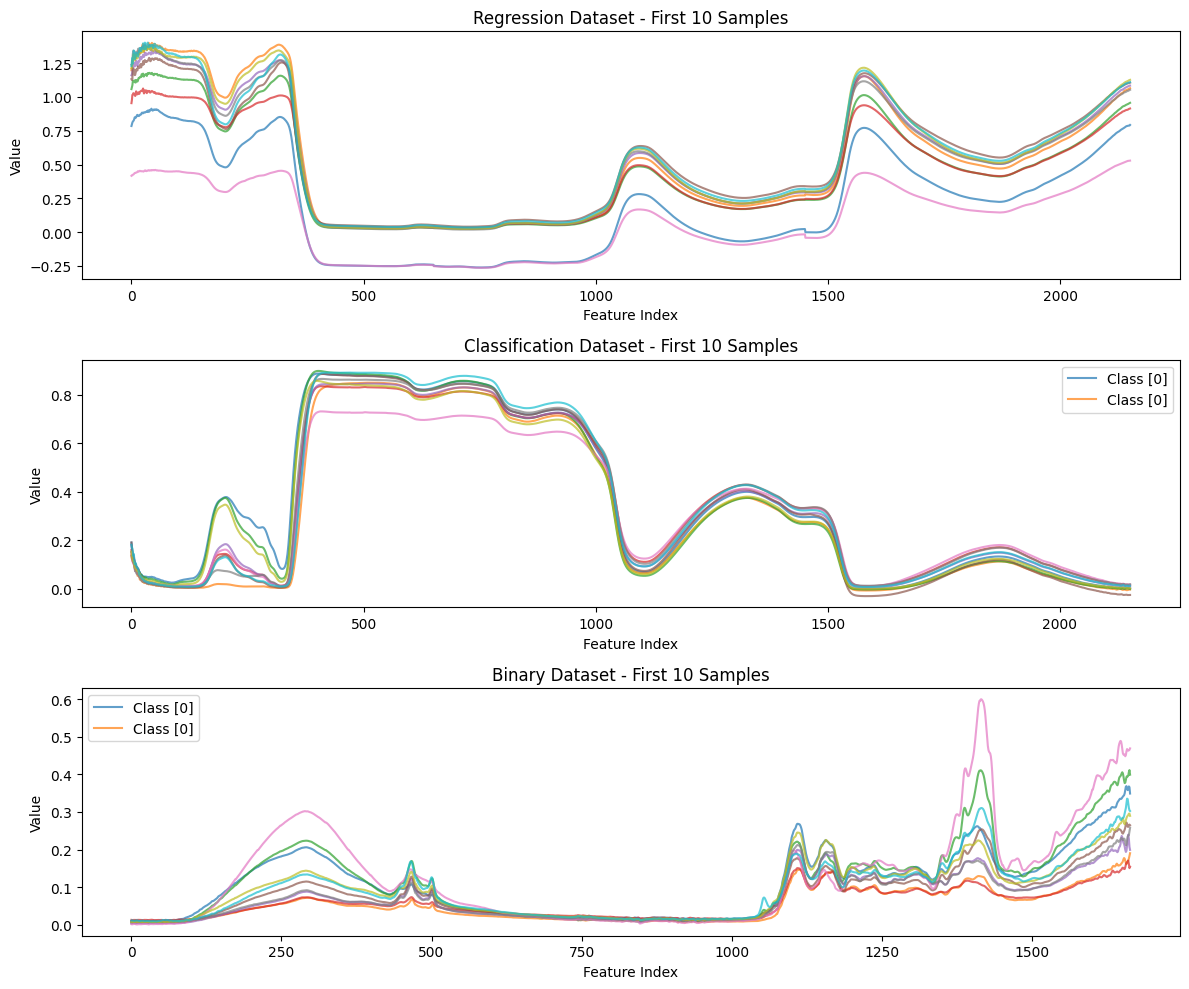

In [14]:
plt.figure(figsize=(12, 10))

# Plot the regression dataset (first 10 samples)
plt.subplot(3, 1, 1)
for i in range(min(10, regression_dataset.x_train_().shape[0])):
    plt.plot(regression_dataset.x_train_()[i], alpha=0.7)
plt.title('Regression Dataset - First 10 Samples')
plt.xlabel('Feature Index')
plt.ylabel('Value')

# Plot the classification dataset (first 10 samples)
plt.subplot(3, 1, 2)
for i in range(min(10, classification_dataset.x_train_().shape[0])):
    plt.plot(classification_dataset.x_train_()[i], alpha=0.7, label=f'Class {classification_dataset.y_train[i]}' if i < 2 else '')
plt.title('Classification Dataset - First 10 Samples')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

# Plot the binary dataset (first 10 samples)
plt.subplot(3, 1, 3)
for i in range(min(10, binary_dataset.x_train_().shape[0])):
    plt.plot(binary_dataset.x_train_()[i], alpha=0.7, label=f'Class {binary_dataset.y_train[i]}' if i < 2 else '')
plt.title('Binary Dataset - First 10 Samples')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

## 9. Advanced Data Visualization 🔰

Let's create more insightful visualizations of our spectral data to better understand it.

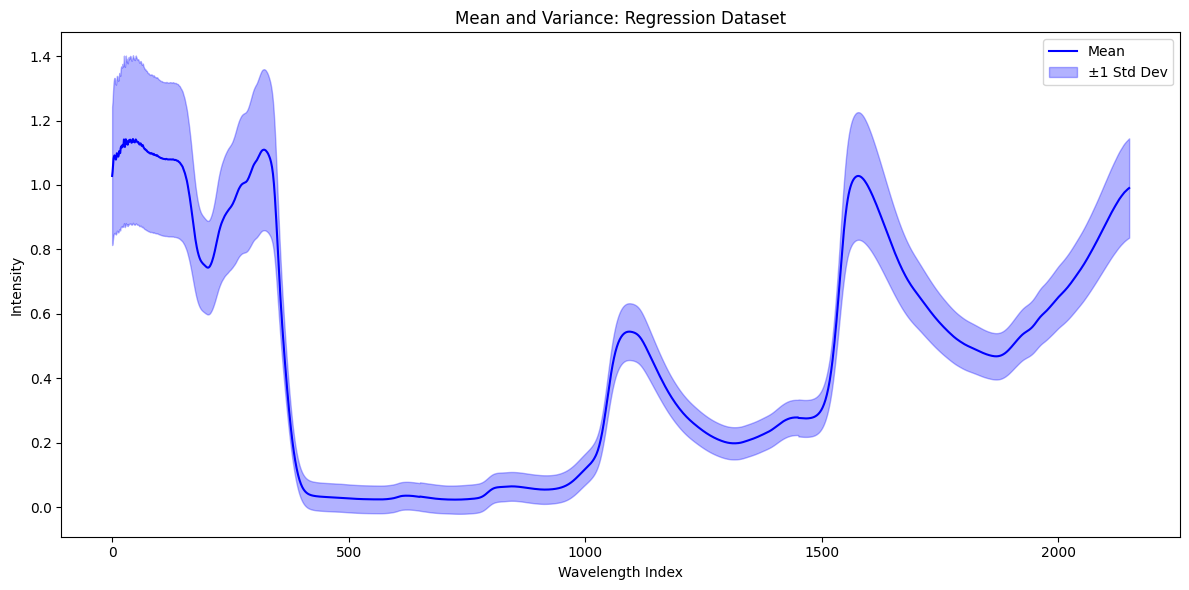

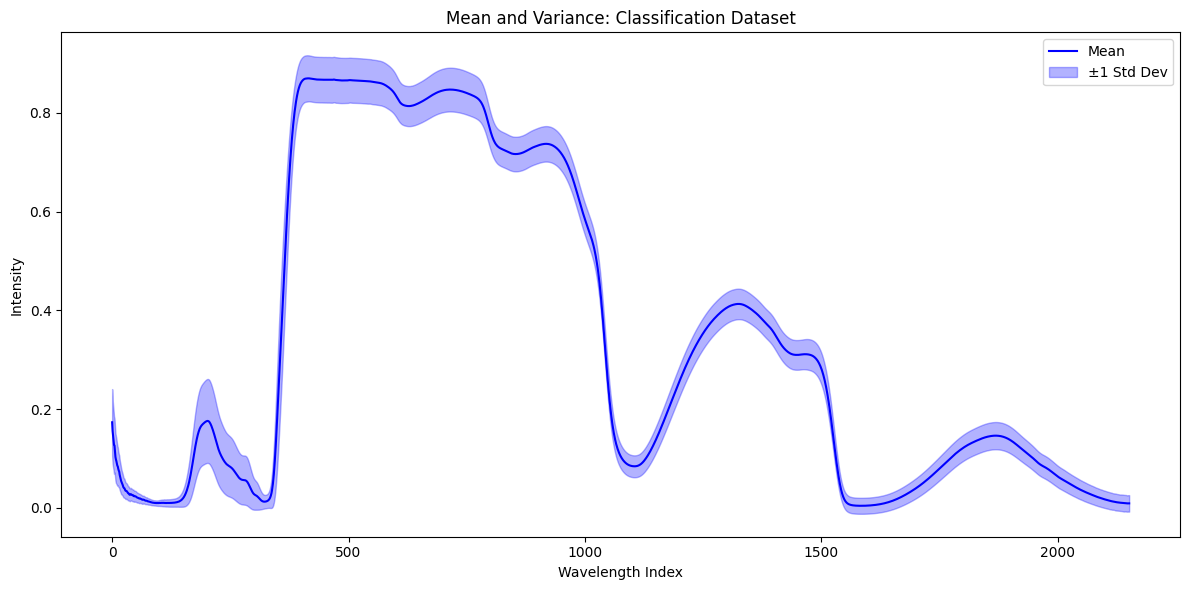

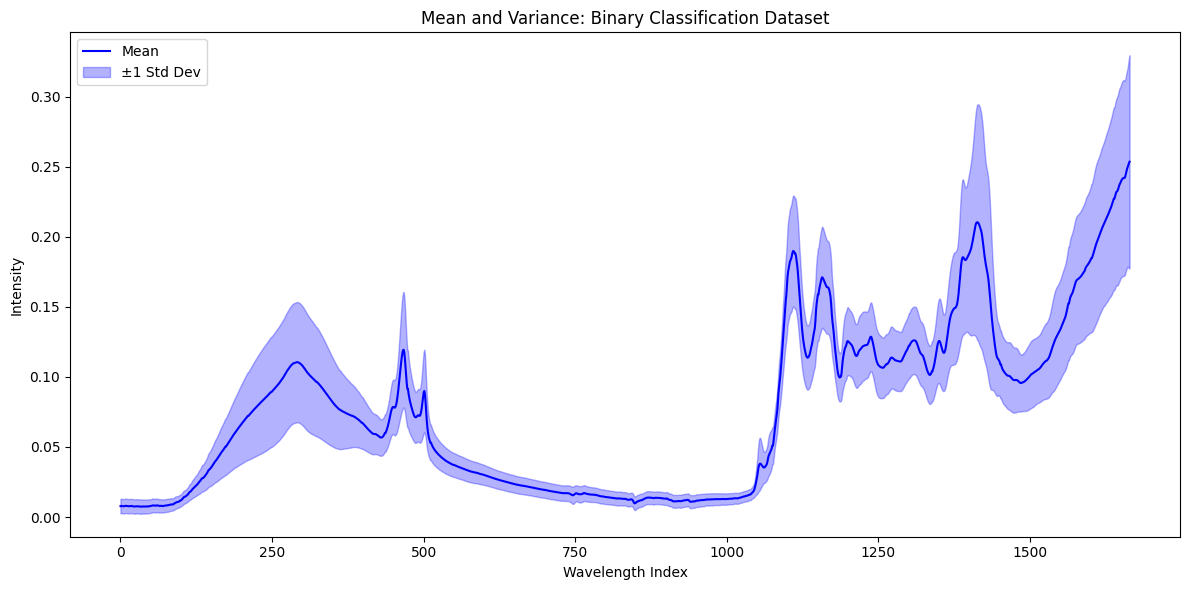

In [15]:
# 9.1 Spectral Mean and Variance Plots

def plot_mean_variance(dataset, title):
    x_data = dataset.x_train_()
    mean_spectrum = np.mean(x_data, axis=0).squeeze()
    std_spectrum = np.std(x_data, axis=0).squeeze()
    x_axis = np.arange(mean_spectrum.shape[0])
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, mean_spectrum, 'b-', label='Mean')
    plt.fill_between(x_axis, 
                     mean_spectrum - std_spectrum, 
                     mean_spectrum + std_spectrum, 
                     alpha=0.3, color='blue', label='±1 Std Dev')
    plt.title(f'Mean and Variance: {title}')
    plt.xlabel('Wavelength Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot mean and variance for each dataset
plot_mean_variance(regression_dataset, 'Regression Dataset')
plot_mean_variance(classification_dataset, 'Classification Dataset')
plot_mean_variance(binary_dataset, 'Binary Classification Dataset')

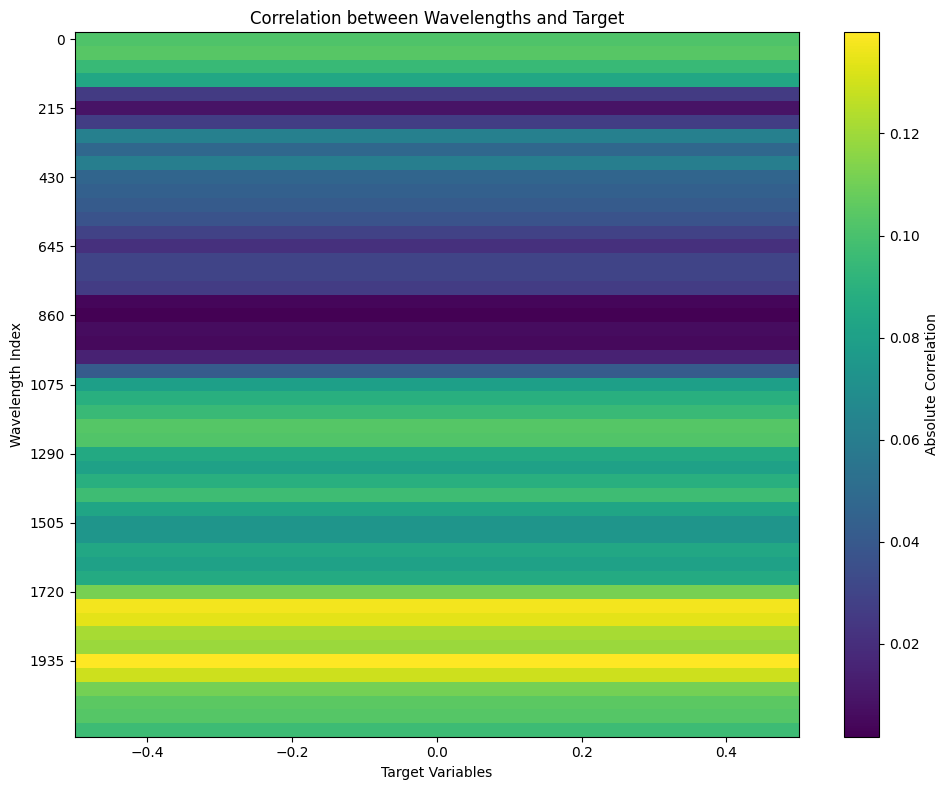

In [16]:
# 9.2 Correlation Heatmaps
# Visualize correlations between wavelengths and target values

def plot_correlation_heatmap(dataset, n_features=50):
    """Plot correlation between spectral features and target variable"""
    
    # Get data and reshape if needed
    X = dataset.x_train_().squeeze()
    y = dataset.y_train
    
    # If X has too many features, sample them for better visualization
    if X.shape[1] > n_features:
        step = X.shape[1] // n_features
        X_sampled = X[:, ::step]
        feature_indices = [i*step for i in range(n_features)]
    else:
        X_sampled = X
        feature_indices = list(range(X.shape[1]))
    
    # Calculate correlations
    corr_matrix = np.zeros((X_sampled.shape[1], y.shape[1]))
    for i in range(X_sampled.shape[1]):
        for j in range(y.shape[1]):
            corr_matrix[i, j] = np.abs(np.corrcoef(X_sampled[:, i], y[:, j])[0, 1])
    
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Absolute Correlation')
    plt.title('Correlation between Wavelengths and Target')
    plt.xlabel('Target Variables')
    plt.ylabel('Wavelength Index')
    plt.yticks(range(0, len(feature_indices), max(1, len(feature_indices)//10)), 
               [feature_indices[i] for i in range(0, len(feature_indices), max(1, len(feature_indices)//10))])
    plt.tight_layout()
    plt.show()

# Only plot for regression dataset as it makes more sense
plot_correlation_heatmap(regression_dataset)

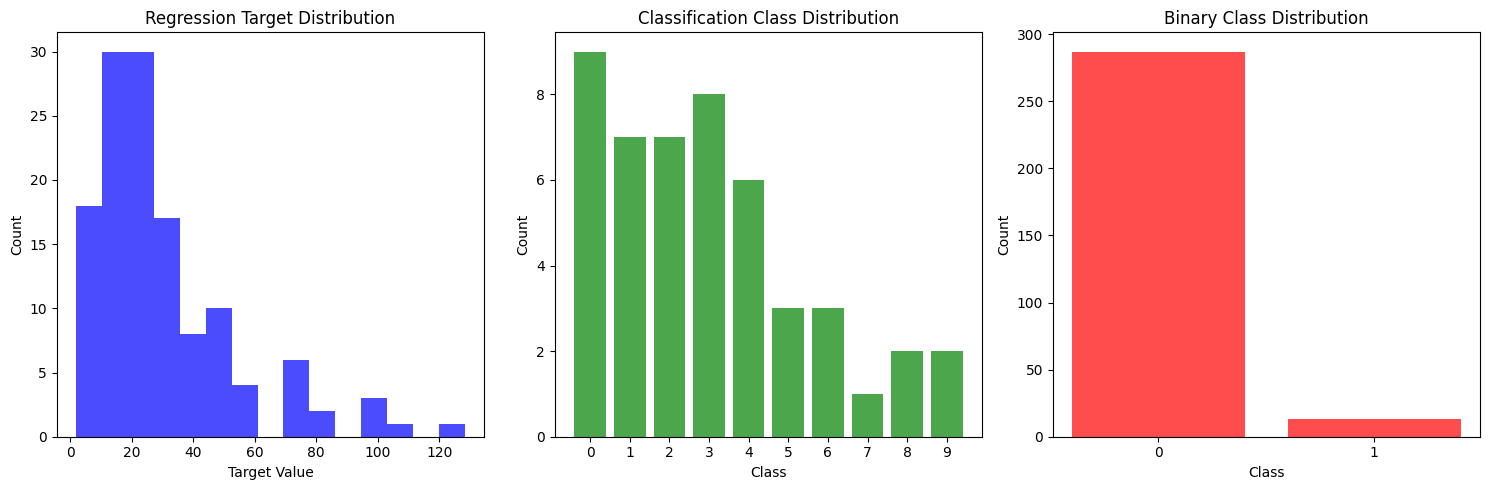

In [17]:
# 9.3 Sample Distribution Plots
# Visualize the distribution of target values

plt.figure(figsize=(15, 5))

# Regression dataset target distribution
plt.subplot(1, 3, 1)
plt.hist(regression_dataset.y_train, bins=15, color='blue', alpha=0.7)
plt.title('Regression Target Distribution')
plt.xlabel('Target Value')
plt.ylabel('Count')

# Classification dataset class distribution
plt.subplot(1, 3, 2)
class_counts = np.bincount(classification_dataset.y_train.flatten())
plt.bar(range(len(class_counts)), class_counts, color='green', alpha=0.7)
plt.title('Classification Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(len(class_counts)))

# Binary dataset class distribution
plt.subplot(1, 3, 3)
binary_counts = np.bincount(binary_dataset.y_train.flatten())
plt.bar(range(len(binary_counts)), binary_counts, color='red', alpha=0.7)
plt.title('Binary Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(len(binary_counts)))

plt.tight_layout()
plt.show()

## 3. Basic Processing Pipeline 🔰

Now, let's create a simple processing pipeline using nirs4all's transformations. This will demonstrate how to preprocess data before training models.

In [18]:
# Define a simple processing pipeline
simple_pipeline = [
    RobustScaler(),  # Step 1: Scale the data
    {"split": RepeatedKFold(n_splits=3, n_repeats=1)},  # Step 2: Define cross-validation splits
    MinMaxScaler()  # Step 3: Scale the data again after splitting
]

# Create a basic configuration
y_pipeline = MinMaxScaler()  # For scaling the target variable
basic_config = Config("../sample_data/regression", simple_pipeline, y_pipeline, None, None, seed)

# Run the experiment with processing only (no model)
start = time.time()
runner = ExperimentRunner([basic_config], resume_mode="restart")
datasets, _, _, _  = runner.run()
dataset = datasets[0]
end = time.time()
print(f"Processing time: {end-start:.2f} seconds")

# Examine the processed dataset
print(f"Processed dataset X shape: {dataset.x_train_().shape}")
print(f"Processed dataset y shape: {dataset.y_train.shape}")

2025-05-13 14:05:59,097 - INFO - ================================================================================
2025-05-13 14:05:59,098 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=None, experiment=None, seed=42)
2025-05-13 14:05:59,099 - INFO - ================================================================================
2025-05-13 14:05:59,100 - INFO - ### LOADING DATASET ###
2025-05-13 14:05:59,098 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=None, experiment=None, seed=42)
2025-05-13 14:05:59,099 - INFO - ================================================================================
2025-05-13 14:05:59,100 - INFO - ### LOADING DATASET ##

>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:06:00,230 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:06:00,232 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:06:00,232 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:06:00,392 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:06:00,393 - INFO - ### PREPARING MODEL ###
2025-05-13 14:06:00,394 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': F

Processing time: 1.30 seconds
Processed dataset X shape: (130, 2151)
Processed dataset y shape: (130, 1)


Let's visualize the processed data to see how it differs from the original:

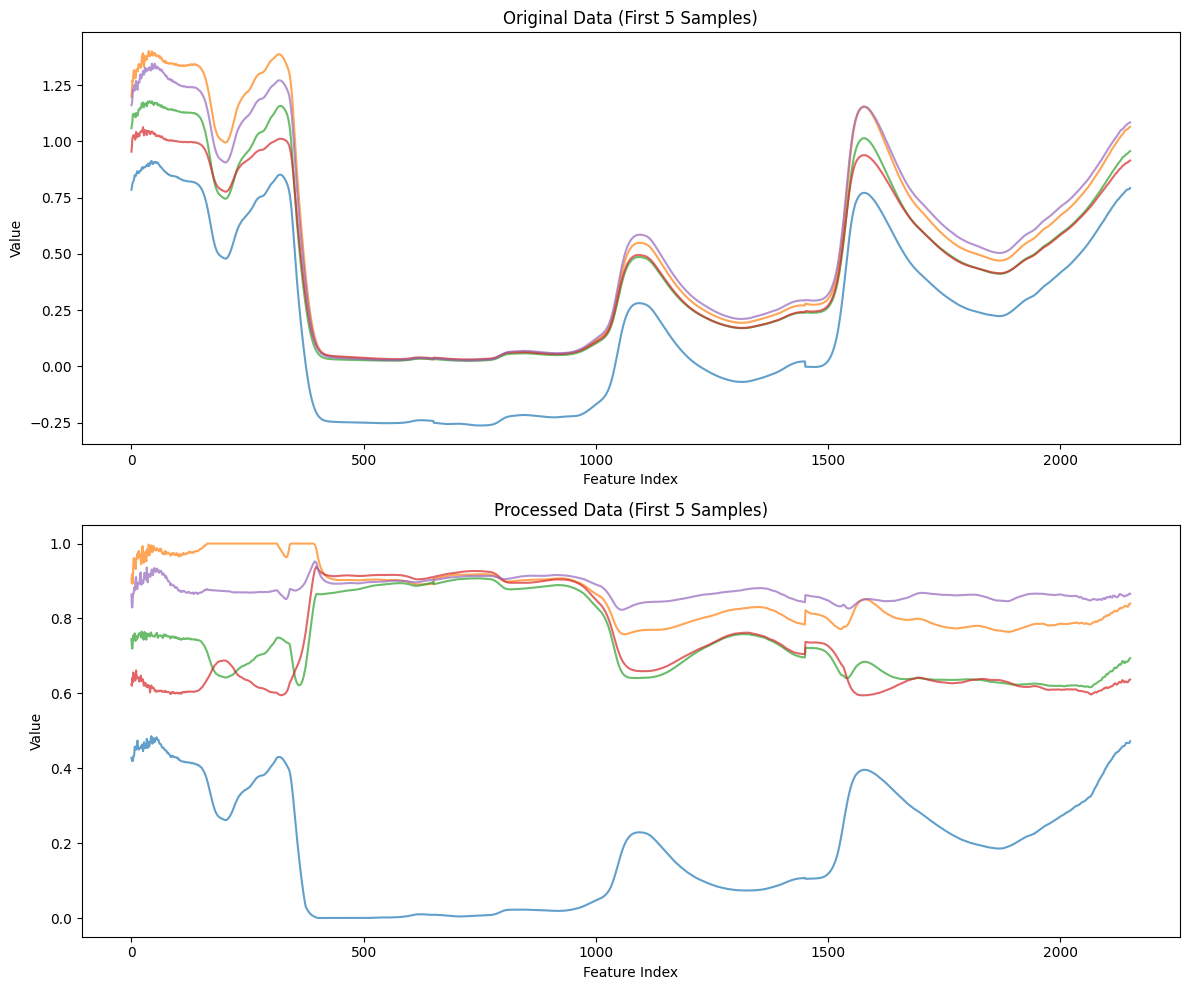

In [19]:
plt.figure(figsize=(12, 10))

# Plot original data
plt.subplot(2, 1, 1)
for i in range(min(5, regression_dataset.x_train_().shape[0])):
    plt.plot(regression_dataset.x_train_()[i], alpha=0.7)
plt.title('Original Data (First 5 Samples)')
plt.xlabel('Feature Index')
plt.ylabel('Value')

# Plot processed data
plt.subplot(2, 1, 2)
for i in range(min(5, dataset.x_train_().shape[0])):
    plt.plot(dataset.x_train_()[i], alpha=0.7)
plt.title('Processed Data (First 5 Samples)')
plt.xlabel('Feature Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

## 10. Transformation Effects Visualization 🔰

Let's visualize how different transformations affect the spectral data:

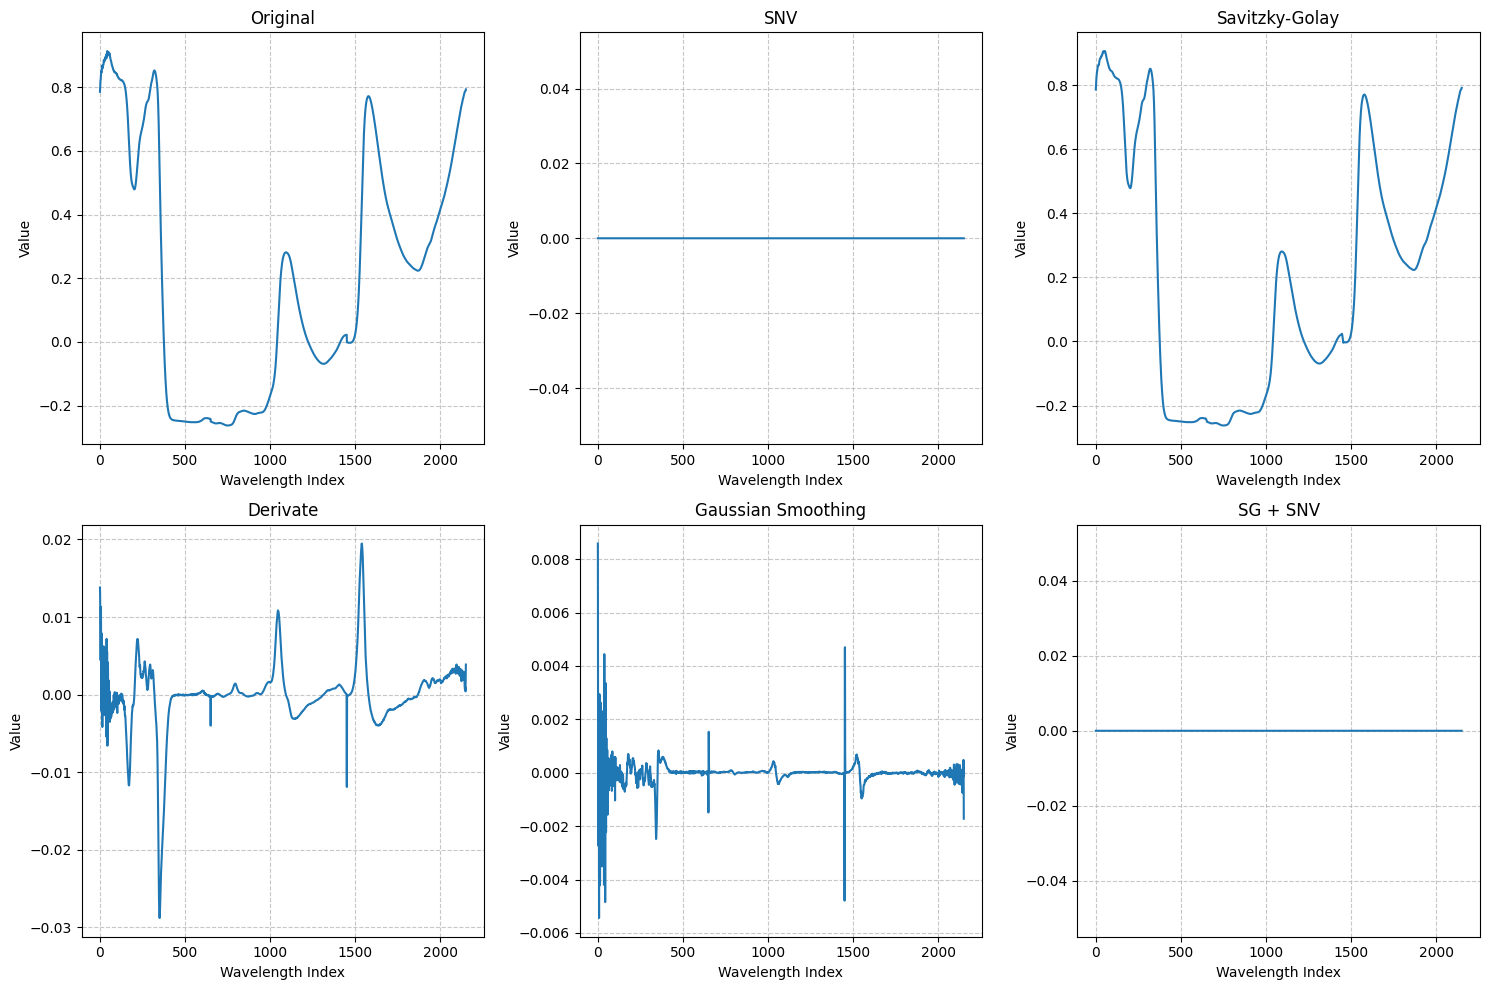

In [22]:
# Define transformations to visualize
transformations = {
    "Original": None,
    "SNV": SNV(),
    "Savitzky-Golay": SG(),
    "Derivate": Dv(),
    "Gaussian Smoothing": GS(2, 1),
    "SG + SNV": [SG(), SNV()]
}

# Helper function to apply a transformation to data
def apply_transformation(X, transform):
    if transform is None:
        return X
    elif isinstance(transform, list):
        result = X.copy()
        for t in transform:
            # For the Derivate transformation, reshape differently
            if isinstance(t, Dv):
                # Apply to 2D array with multiple samples in one dimension
                reshaped = result.reshape(-1, 1)
                t.fit(reshaped)
                result = t.transform(reshaped).squeeze()
            else:
                t.fit(result)
                result = t.transform(result)
        return result
    else:
        # Special case for Derivate
        if isinstance(transform, Dv):
            # Apply to 2D array with multiple samples in one dimension
            reshaped = X.reshape(-1, 1)
            transform.fit(reshaped)
            return transform.transform(reshaped).squeeze()
        else:
            transform.fit(X)
            return transform.transform(X)

# Get a sample spectrum
sample_spectrum = regression_dataset.x_train_()[0].squeeze()

# Plot the transformations
plt.figure(figsize=(15, 10))
rows, cols = 2, 3
for i, (name, transform) in enumerate(transformations.items()):
    plt.subplot(rows, cols, i+1)
    
    # Apply transformation and plot
    if transform is not None:
        if isinstance(transform, list):
            transformed = sample_spectrum.copy()
            for t in transform:
                # For the Derivate transformation, reshape differently
                if isinstance(t, Dv):
                    # Apply to 2D array with multiple samples in one dimension
                    reshaped = transformed.reshape(-1, 1)
                    t.fit(reshaped)
                    transformed = t.transform(reshaped).squeeze()
                else:
                    t.fit(transformed.reshape(1, -1))
                    transformed = t.transform(transformed.reshape(1, -1)).squeeze()
        else:
            # Special case for Derivate
            if isinstance(transform, Dv):
                # Apply to 2D array with multiple samples in one dimension
                reshaped = sample_spectrum.reshape(-1, 1)
                transform.fit(reshaped)
                transformed = transform.transform(reshaped).squeeze()
            else:
                transform.fit(sample_spectrum.reshape(1, -1))
                transformed = transform.transform(sample_spectrum.reshape(1, -1)).squeeze()
    else:
        transformed = sample_spectrum
    
    plt.plot(transformed)
    plt.title(f"{name}")
    plt.xlabel("Wavelength Index")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

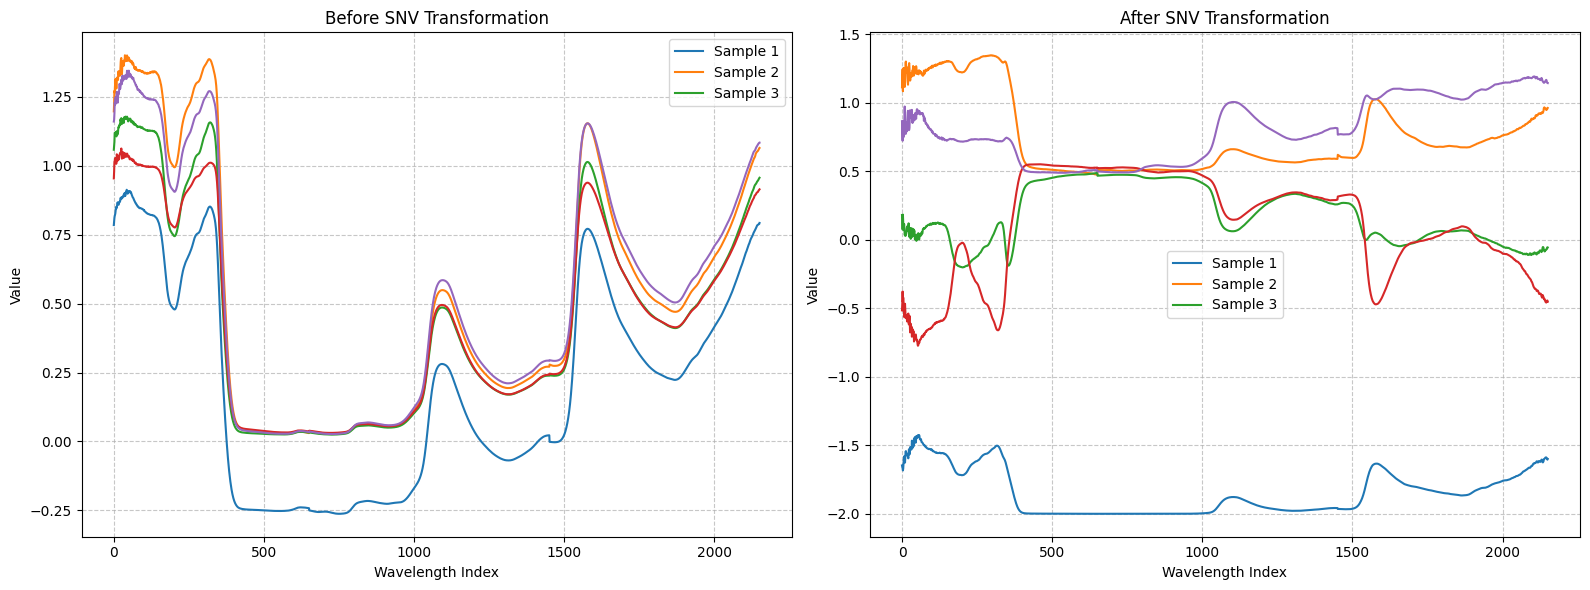

In [23]:
# Side-by-side comparison of before/after transformations
# Choose a simple transformation for this example
transformation = SNV()

# Get data samples
sample_spectra = regression_dataset.x_train_()[:5].squeeze()

# Apply transformation
transformation.fit(sample_spectra)
transformed_spectra = transformation.transform(sample_spectra)

# Plot before and after
plt.figure(figsize=(16, 6))

# Before transformation
plt.subplot(1, 2, 1)
for i, spectrum in enumerate(sample_spectra):
    plt.plot(spectrum, label=f"Sample {i+1}" if i < 3 else "")
plt.title("Before SNV Transformation")
plt.xlabel("Wavelength Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# After transformation
plt.subplot(1, 2, 2)
for i, spectrum in enumerate(transformed_spectra):
    plt.plot(spectrum, label=f"Sample {i+1}" if i < 3 else "")
plt.title("After SNV Transformation")
plt.xlabel("Wavelength Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 4. Training scikit-learn Models 🔰

Now that we understand how to process data, let's train some scikit-learn models. We'll start with a simple PLS regression model.

In [24]:
# Define an sklearn model using a dictionary
sklearn_pls_model = {
    "class": "sklearn.cross_decomposition.PLSRegression",
    "model_params": {
        "n_components": 5,
    }
}

# Define a pipeline with transformations
sklearn_pipeline = [
    RobustScaler(),
    {"split": RepeatedKFold(n_splits=5, n_repeats=1)},
    {"features": [None, GS(2, 1), SG, SNV, Dv]},  # Try different feature transformations
    MinMaxScaler()
]

# Create a configuration for training
sklearn_config = Config("../sample_data/regression", sklearn_pipeline, y_pipeline, sklearn_pls_model, None, seed)

# Run the training experiment
print("Training sklearn PLS model...")
start = time.time()
runner = ExperimentRunner([sklearn_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:14:04,815 - INFO - ================================================================================
2025-05-13 14:14:04,817 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=5, random_state=None)}, {'features': [None, Gaussian(), <class 'nirs4all.transformations._nirs.SavitzkyGolay'>, <class 'sklearn.preprocessing._data.StandardScaler'>, <class 'nirs4all.transformations._scaler.Derivate'>]}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 5}}, experiment=None, seed=42)
2025-05-13 14:14:04,818 - INFO - ================================================================================
2025-05-13 14:14:04,819 - INFO - ### LOADING DATASET ###
2025-05-13 14:14:04,817 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, 

Training sklearn PLS model...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:14:05,839 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:14:05,839 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:05,839 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:06,042 - INFO - Dataset(x_train:(130, 10755) - y_train:(130, 1), x_test:(59, 10755) - y_test:(59, 1))
Folds size: 104-26, 104-26, 104-26, 104-26, 104-26
2025-05-13 14:14:06,042 - INFO - ### PREPARING MODEL ###
2025-05-13 14:14:06,045 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 5}}}}, {'features': [None, {'class': 'nirs4all.transfo

Using framework: sklearn
Training fold 1, with shapes: (104, 10755) (104, 1) (26, 10755) (26, 1)
Training fold 2, with shapes: (104, 10755) (104, 1) (26, 10755) (26, 1)
Training fold 3, with shapes: (104, 10755) (104, 1) (26, 10755) (26, 1)
Training fold 4, with shapes: (104, 10755) (104, 1) (26, 10755) (26, 1)
Training fold 5, with shapes: (104, 10755) (104, 1) (26, 10755) (26, 1)


2025-05-13 14:14:06,229 - INFO - Updated experiments at results\sample_dataregression\experiments.json
2025-05-13 14:14:06,231 - INFO - Updated experiments at results\sample_dataregression\PLSRegression\experiments.json and results\sample_dataregression\experiments.json
2025-05-13 14:14:06,231 - INFO - All experiments completed.
2025-05-13 14:14:06,231 - INFO - Updated experiments at results\sample_dataregression\PLSRegression\experiments.json and results\sample_dataregression\experiments.json
2025-05-13 14:14:06,231 - INFO - All experiments completed.


Training time: 1.42 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 397.2413567883398, 'mae': 15.947995549530557}
  Fold 2: {'mse': 421.21669784671514, 'mae': 16.706162866296413}
  Fold 3: {'mse': 428.17945395174326, 'mae': 16.648052809389046}
  Fold 4: {'mse': 420.8075461477036, 'mae': 16.595016940094222}
  Fold 5: {'mse': 429.3828933526354, 'mae': 16.69984156321898}
  Mean: {'mse': 415.5961909117582, 'mae': 16.45229597407534}
  Best: {'mse': 397.2413567883398, 'mae': 15.947995549530557}
  Weighted Mean: {'mse': 415.18909889885714, 'mae': 16.441867724795205}


Let's also try a Random Forest classifier for a classification task:

In [25]:
# Define a Random Forest classifier model
sklearn_rf_model = {
    "class": "sklearn.ensemble.RandomForestClassifier",
    "model_params": {
        "n_estimators": 30,
        "max_depth": 15,
    }
}

# Create a configuration for classification training
sklearn_class_config = Config(
    "../sample_data/classification", 
    sklearn_pipeline, 
    None,
    sklearn_rf_model, 
    {"task": "classification"},  # Specify the task type
    seed
)

# Run the classification training experiment
print("Training sklearn Random Forest classifier...")
start = time.time()
runner = ExperimentRunner([sklearn_class_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:14:25,614 - INFO - ================================================================================
2025-05-13 14:14:25,615 - INFO - Running config: Config(dataset='../sample_data/classification', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=5, random_state=None)}, {'features': [None, Gaussian(), <class 'nirs4all.transformations._nirs.SavitzkyGolay'>, <class 'sklearn.preprocessing._data.StandardScaler'>, <class 'nirs4all.transformations._scaler.Derivate'>]}, MinMaxScaler()], y_pipeline=None, model={'class': 'sklearn.ensemble.RandomForestClassifier', 'model_params': {'n_estimators': 30, 'max_depth': 15}}, experiment={'task': 'classification'}, seed=42)
2025-05-13 14:14:25,616 - INFO - ================================================================================
2025-05-13 14:14:25,617 - INFO - ### LOADING DATASET ###
2025-05-13 14:14:25,615 - INFO - Running config: Config(dataset='../sample_data/classification', x_pipeline=[RobustScaler(), {

Training sklearn Random Forest classifier...
>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.


2025-05-13 14:14:26,400 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
2025-05-13 14:14:26,401 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:26,401 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:26,562 - INFO - Dataset(x_train:(48, 10760) - y_train:(48, 1), x_test:(18, 10760) - y_test:(18, 1))
Folds size: 38-10, 38-10, 38-10, 39-9, 39-9
2025-05-13 14:14:26,563 - INFO - ### PREPARING MODEL ###
2025-05-13 14:14:26,565 - INFO - Running config > {'dataset': '../sample_data/classification', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 5}}}}, {'features': [None, {'class': 'nirs4all.transformation

Using framework: sklearn
Training fold 1, with shapes: (38, 10760) (38, 1) (10, 10760) (10, 1)
Training fold 2, with shapes: (38, 10760) (38, 1) (10, 10760) (10, 1)
Training fold 3, with shapes: (38, 10760) (38, 1) (10, 10760) (10, 1)
Training fold 3, with shapes: (38, 10760) (38, 1) (10, 10760) (10, 1)
Training fold 4, with shapes: (39, 10760) (39, 1) (9, 10760) (9, 1)
Training fold 4, with shapes: (39, 10760) (39, 1) (9, 10760) (9, 1)
Training fold 5, with shapes: (39, 10760) (39, 1) (9, 10760) (9, 1)
Training fold 5, with shapes: (39, 10760) (39, 1) (9, 10760) (9, 1)


2025-05-13 14:14:27,770 - INFO - Saved model to results\sample_dataclassification\RandomForestClassifier\experiment_9b5a2ab6
2025-05-13 14:14:27,802 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.1111111111111111}
2025-05-13 14:14:27,804 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.16666666666666666}
2025-05-13 14:14:27,805 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.2222222222222222}
2025-05-13 14:14:27,806 - INFO - Evaluation Metrics fold_3: {'accuracy': 0.16666666666666666}
2025-05-13 14:14:27,807 - INFO - Evaluation Metrics fold_4: {'accuracy': 0.16666666666666666}
2025-05-13 14:14:27,808 - INFO - Evaluation Metrics mean: {'accuracy': 0.16666666666666666}
2025-05-13 14:14:27,809 - INFO - Evaluation Metrics best: {'accuracy': 0.2222222222222222}
2025-05-13 14:14:27,809 - INFO - Evaluation Metrics weighted: {'accuracy': 0.2222222222222222}
2025-05-13 14:14:27,811 - INFO - Metrics saved to results\sample_dataclassification\RandomForestClassifier\experiment_9b5a2ab6\me

Training time: 2.22 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.1111111111111111}
  Fold 2: {'accuracy': 0.16666666666666666}
  Fold 3: {'accuracy': 0.2222222222222222}
  Fold 4: {'accuracy': 0.16666666666666666}
  Fold 5: {'accuracy': 0.16666666666666666}
  Mean: {'accuracy': 0.16666666666666666}
  Best: {'accuracy': 0.2222222222222222}
  Weighted Mean: {'accuracy': 0.2222222222222222}


## 5. Training TensorFlow Models 🔰 🔶

Next, let's try training TensorFlow-based models with nirs4all. We'll use the pre-defined models like `nicon` as well as create custom models.

In [26]:
try:
    import tensorflow as tf
    tf_available = True
    print("TensorFlow version:", tf.__version__)
except ImportError:
    tf_available = False
    print("TensorFlow is not available. Skipping TensorFlow examples.")

TensorFlow version: 2.19.0


In [27]:
if tf_available:
    # Define TensorFlow training parameters
    tf_train_params = {
        "action": "train", 
        "training_params": {
            "epochs": 50, 
            "batch_size": 32, 
            "patience": 10,
            "verbose": 0
        }
    }
    
    # Define a pipeline with transformations
    tf_pipeline = [
        RobustScaler(),
        {"split": RepeatedKFold(n_splits=3, n_repeats=1)},
        MinMaxScaler()
    ]
    
    # Create a configuration for training with the preset nicon model
    tf_config = Config(
        "../sample_data/regression", 
        tf_pipeline, 
        y_pipeline, 
        nicon,  # Using the preset nicon model
        tf_train_params, 
        seed
    )
    
    # Run the training experiment
    print("Training TensorFlow nicon model...")
    start = time.time()
    runner = ExperimentRunner([tf_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:14:35,568 - INFO - ================================================================================
2025-05-13 14:14:35,569 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function nicon at 0x000002446DCB1EA0>, experiment={'action': 'train', 'training_params': {'epochs': 50, 'batch_size': 32, 'patience': 10, 'verbose': 0}}, seed=42)
2025-05-13 14:14:35,570 - INFO - ================================================================================
2025-05-13 14:14:35,570 - INFO - ### LOADING DATASET ###
2025-05-13 14:14:35,569 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function nicon at 0x000002446DCB1EA0>, experiment={'action': 'train'

Training TensorFlow nicon model...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:14:36,707 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:14:36,708 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:36,708 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:36,868 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:14:36,869 - INFO - ### PREPARING MODEL ###
2025-05-13 14:14:36,868 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:14:36,869 - INFO - ### PREPARING MODEL ###
2025-05-13 14:14:37,003 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (86, 2151, 1), (86, 1), (44, 2151, 1), (44, 1)
mse ['mse', 'mae']
Training with shapes: (86, 2151, 1) (86, 1) (44, 2151, 1) (44, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)


2025-05-13 14:14:50,230 - INFO - Saved model to results\sample_dataregression\nicon\experiment_8237c92a


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/stepWARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000244725B8430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/stepWARNING:tensorflow:6 out of the last 6 calls to 

2025-05-13 14:14:51,074 - INFO - Evaluation Metrics fold_0: {'mse': 448.7839327161966, 'mae': 17.829848221601065}
2025-05-13 14:14:51,076 - INFO - Evaluation Metrics fold_1: {'mse': 405.78625951544467, 'mae': 15.801159969265177}
2025-05-13 14:14:51,077 - INFO - Evaluation Metrics fold_2: {'mse': 411.72390825755474, 'mae': 17.33277874962758}
2025-05-13 14:14:51,077 - INFO - Evaluation Metrics mean: {'mse': 404.5806479052316, 'mae': 16.792571986570195}
2025-05-13 14:14:51,079 - INFO - Evaluation Metrics best: {'mse': 405.78625951544467, 'mae': 15.801159969265177}
2025-05-13 14:14:51,080 - INFO - Evaluation Metrics weighted: {'mse': 403.57120078065344, 'mae': 16.76012652848505}
2025-05-13 14:14:51,081 - INFO - Metrics saved to results\sample_dataregression\nicon\experiment_8237c92a\metrics.json
2025-05-13 14:14:51,083 - INFO - Predictions saved to results\sample_dataregression\nicon\experiment_8237c92a\predictions.csv
2025-05-13 14:14:51,076 - INFO - Evaluation Metrics fold_1: {'mse': 405

Training time: 15.54 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 448.7839327161966, 'mae': 17.829848221601065}
  Fold 2: {'mse': 405.78625951544467, 'mae': 15.801159969265177}
  Fold 3: {'mse': 411.72390825755474, 'mae': 17.33277874962758}
  Mean: {'mse': 404.5806479052316, 'mae': 16.792571986570195}
  Best: {'mse': 405.78625951544467, 'mae': 15.801159969265177}
  Weighted Mean: {'mse': 403.57120078065344, 'mae': 16.76012652848505}


### 5.1. Custom TensorFlow Model

Now let's create a custom TensorFlow model and train it using nirs4all:

In [28]:
if tf_available:
    # Define a custom TensorFlow regression model
    @framework('tensorflow')
    def custom_tf_regression(input_shape, params={}):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
        
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(params.get('units1', 32), activation=params.get('activation1', "relu")))
        model.add(Dropout(params.get('dropout1', 0.1)))
        model.add(Dense(params.get('units2', 64), activation=params.get('activation2', "relu")))
        model.add(Dropout(params.get('dropout2', 0.2)))
        model.add(Flatten())
        model.add(Dense(params.get('units3', 16), activation=params.get('activation3', "relu")))
        model.add(Dense(1, activation="linear"))  # Output layer for regression
        return model
    
    # Create a configuration for training with the custom TF model
    custom_tf_config = Config(
        "../sample_data/regression", 
        tf_pipeline, 
        y_pipeline, 
        custom_tf_regression,  # Using our custom TF model
        tf_train_params, 
        seed
    )
    
    # Run the training experiment
    print("Training custom TensorFlow regression model...")
    start = time.time()
    runner = ExperimentRunner([custom_tf_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:14:55,623 - INFO - ================================================================================
2025-05-13 14:14:55,623 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function custom_tf_regression at 0x0000024472BA6440>, experiment={'action': 'train', 'training_params': {'epochs': 50, 'batch_size': 32, 'patience': 10, 'verbose': 0}, 'metrics': ['mse', 'mae'], 'task': 'regression'}, seed=42)
2025-05-13 14:14:55,625 - INFO - ================================================================================
2025-05-13 14:14:55,626 - INFO - ### LOADING DATASET ###
2025-05-13 14:14:55,623 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<func

Training custom TensorFlow regression model...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:14:56,620 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:14:56,621 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:56,621 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:14:56,781 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:14:56,782 - INFO - ### PREPARING MODEL ###
2025-05-13 14:14:56,781 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:14:56,782 - INFO - ### PREPARING MODEL ###
2025-05-13 14:14:56,872 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (86, 2151, 1), (86, 1), (44, 2151, 1), (44, 1)
mse ['mse', 'mae']
Training with shapes: (86, 2151, 1) (86, 1) (44, 2151, 1) (44, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)


2025-05-13 14:15:16,319 - INFO - Saved model to results\sample_dataregression\custom_tf_regression\experiment_86bf3f6f


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


2025-05-13 14:15:16,743 - INFO - Evaluation Metrics fold_0: {'mse': 1278.121888711877, 'mae': 29.786628642647948}
2025-05-13 14:15:16,745 - INFO - Evaluation Metrics fold_1: {'mse': 1141.9694059435492, 'mae': 27.603143562381547}
2025-05-13 14:15:16,746 - INFO - Evaluation Metrics fold_2: {'mse': 1277.996026273564, 'mae': 29.784585902569653}
2025-05-13 14:15:16,747 - INFO - Evaluation Metrics mean: {'mse': 1231.4354195406124, 'mae': 29.029354604300803}
2025-05-13 14:15:16,748 - INFO - Evaluation Metrics best: {'mse': 1141.9694059435492, 'mae': 27.603143562381547}
2025-05-13 14:15:16,749 - INFO - Evaluation Metrics weighted: {'mse': 1227.9246661067862, 'mae': 28.974864959392004}
2025-05-13 14:15:16,750 - INFO - Metrics saved to results\sample_dataregression\custom_tf_regression\experiment_86bf3f6f\metrics.json
2025-05-13 14:15:16,753 - INFO - Predictions saved to results\sample_dataregression\custom_tf_regression\experiment_86bf3f6f\predictions.csv
2025-05-13 14:15:16,745 - INFO - Evalua

Training time: 21.15 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 1278.121888711877, 'mae': 29.786628642647948}
  Fold 2: {'mse': 1141.9694059435492, 'mae': 27.603143562381547}
  Fold 3: {'mse': 1277.996026273564, 'mae': 29.784585902569653}
  Mean: {'mse': 1231.4354195406124, 'mae': 29.029354604300803}
  Best: {'mse': 1141.9694059435492, 'mae': 27.603143562381547}
  Weighted Mean: {'mse': 1227.9246661067862, 'mae': 28.974864959392004}


### 5.2. Classification with TensorFlow

Let's also train a TensorFlow model for classification:

In [29]:
if tf_available:
    # Define TensorFlow classification training parameters
    tf_class_train_params = {
        "action": "train", 
        "task": "classification",
        "training_params": {
            "epochs": 500, 
            "batch_size": 32, 
            "patience": 50,
            "verbose": 0
        }
    }
    
    # Define a custom TensorFlow classification model
    @framework('tensorflow')
    def custom_tf_classification(input_shape, num_classes=2, params={}):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
        
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(params.get('units1', 32), activation=params.get('activation1', "relu")))
        model.add(Dropout(params.get('dropout1', 0.1)))
        model.add(Dense(params.get('units2', 64), activation=params.get('activation2', "relu")))
        model.add(Dropout(params.get('dropout2', 0.2)))
        model.add(Flatten())
        model.add(Dense(params.get('units3', 16), activation=params.get('activation3', "relu")))
        
        # Output layer depends on number of classes
        if num_classes == 2:
            model.add(Dense(1, activation="sigmoid"))
        else:
            model.add(Dense(num_classes, activation="softmax"))
        
        return model
    
    # Create configurations for both preset and custom classification models
    tf_class_preset_config = Config(
        "../sample_data/classification", 
        tf_pipeline, 
        None,  # No y_pipeline for classification
        nicon_classification,  # Using the preset classification model
        tf_class_train_params, 
        seed
    )
    
    tf_class_custom_config = Config(
        "../sample_data/classification", 
        tf_pipeline, 
        None,  # No y_pipeline for classification
        custom_tf_classification,  # Using our custom classification model
        tf_class_train_params, 
        seed
    )
    
    # Run the preset classification model training
    print("Training preset TensorFlow classification model (nicon_classification)...")
    start = time.time()
    runner = ExperimentRunner([tf_class_preset_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")
    
    # Run the custom classification model training
    print("\nTraining custom TensorFlow classification model...")
    start = time.time()
    runner = ExperimentRunner([tf_class_custom_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Training time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:16:00,635 - INFO - ================================================================================
2025-05-13 14:16:00,636 - INFO - Running config: Config(dataset='../sample_data/classification', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=None, model=<function nicon_classification at 0x000002446DCB23B0>, experiment={'action': 'train', 'task': 'classification', 'training_params': {'epochs': 500, 'batch_size': 32, 'patience': 50, 'verbose': 0}}, seed=42)
2025-05-13 14:16:00,637 - INFO - ================================================================================
2025-05-13 14:16:00,639 - INFO - ### LOADING DATASET ###
2025-05-13 14:16:00,636 - INFO - Running config: Config(dataset='../sample_data/classification', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=None, model=<function nicon_classification at 0x000

Training preset TensorFlow classification model (nicon_classification)...
>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.


2025-05-13 14:16:01,805 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
2025-05-13 14:16:01,806 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:16:01,806 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:16:01,978 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
Folds size: 32-16, 32-16, 32-16
2025-05-13 14:16:01,979 - INFO - ### PREPARING MODEL ###
2025-05-13 14:16:01,978 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
Folds size: 32-16, 32-16, 32-16
2025-05-13 14:16:01,979 - INFO - ### PREPARING MODEL ###
2025-05-13 14:16:02,100 - INFO - Running config > {'dataset': '../sample_data/classification', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params':

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)


2025-05-13 14:16:31,126 - INFO - Saved model to results\sample_dataclassification\nicon_classification\experiment_a48a8563


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


2025-05-13 14:16:31,528 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.05555555555555555}
2025-05-13 14:16:31,529 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.0}
2025-05-13 14:16:31,531 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.05555555555555555}
2025-05-13 14:16:31,532 - INFO - Evaluation Metrics mean: {'accuracy': 0.0}
2025-05-13 14:16:31,533 - INFO - Evaluation Metrics best: {'accuracy': 0.05555555555555555}
2025-05-13 14:16:31,534 - INFO - Evaluation Metrics weighted: {'accuracy': 0.05555555555555555}
2025-05-13 14:16:31,535 - INFO - Metrics saved to results\sample_dataclassification\nicon_classification\experiment_a48a8563\metrics.json
2025-05-13 14:16:31,536 - INFO - Predictions saved to results\sample_dataclassification\nicon_classification\experiment_a48a8563\predictions.csv
2025-05-13 14:16:31,544 - INFO - Updated experiments at results\sample_dataclassification\nicon_classification\experiments.json
2025-05-13 14:16:31,529 - INFO - Evaluation Metrics fold_1:

Training time: 30.92 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.05555555555555555}
  Fold 2: {'accuracy': 0.0}
  Fold 3: {'accuracy': 0.05555555555555555}
  Mean: {'accuracy': 0.0}
  Best: {'accuracy': 0.05555555555555555}
  Weighted Mean: {'accuracy': 0.05555555555555555}

Training custom TensorFlow classification model...


2025-05-13 14:16:31,561 - INFO - ### LOADING DATASET ###


>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.


2025-05-13 14:16:32,359 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
2025-05-13 14:16:32,360 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:16:32,360 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:16:32,508 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
Folds size: 32-16, 32-16, 32-16
2025-05-13 14:16:32,508 - INFO - ### PREPARING MODEL ###
2025-05-13 14:16:32,508 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
Folds size: 32-16, 32-16, 32-16
2025-05-13 14:16:32,508 - INFO - ### PREPARING MODEL ###
2025-05-13 14:16:32,591 - INFO - Running config > {'dataset': '../sample_data/classification', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params':

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)
Training fold with shapes: (32, 2152, 1), (32, 1), (16, 2152, 1), (16, 1)
sparse_categorical_crossentropy ['accuracy']
Training with shapes: (32, 2152, 1) (32,) (16, 2152, 1) (16,)


2025-05-13 14:16:57,913 - INFO - Saved model to results\sample_dataclassification\custom_tf_classification\experiment_21975736


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2025-05-13 14:16:58,209 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.2222222222222222}
2025-05-13 14:16:58,211 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.1111111111111111}
2025-05-13 14:16:58,211 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.2222222222222222}
2025-05-13 14:16:58,212 - INFO - Evaluation Metrics mean: {'accuracy': 0.2222222222222222}
2025-05-13 14:16:58,213 - INFO - Evaluation Metrics best: {'accuracy': 0.2222222222222222}
2025-05-13 14:16:58,214 - INFO - Evaluation Metrics weighted: {'accuracy': 0.2222222222222222}
2025-05-13 14:16:58,215 - INFO - Metrics saved to results\sample_dataclassification\custom_tf_classification\experiment_21975736\metrics.json
2025-05-13 14:16:58,217 - INFO - Predictions saved to results\sample_dataclassification\custom_tf_classification\experiment_21975736\predictions.csv
2025-05-13 14:16:58,227 - INFO - Updated experiments at results\sample_dataclassification\custom_tf_classification\experiments.json
2025-05-13 14:16:58,2

Training time: 26.68 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.2222222222222222}
  Fold 2: {'accuracy': 0.1111111111111111}
  Fold 3: {'accuracy': 0.2222222222222222}
  Mean: {'accuracy': 0.2222222222222222}
  Best: {'accuracy': 0.2222222222222222}
  Weighted Mean: {'accuracy': 0.2222222222222222}


## 6. Fine-tuning Models 🔶

Now let's explore how to fine-tune models in nirs4all. We'll start with fine-tuning sklearn models and then move to TensorFlow models.

### 6.1. Fine-tuning sklearn Models

In [35]:
# Fine-tune a PLS regression model
finetune_pls_experiment = {
    "action": "finetune",
    "finetune_params": {
        'model_params': {
            'n_components': ('int', 5, 20),  # Range of values to try
        },
        'training_params': {},
        'tuner': 'sklearn'
    }
}

# Define the sklearn model to fine-tune
sklearn_pls_model = {
    "class": "sklearn.cross_decomposition.PLSRegression",
    "model_params": {
        "n_components": 10,  # Default value, will be overridden during tuning
    }
}

# Create a configuration for fine-tuning
sklearn_finetune_config = Config(
    "../sample_data/regression", 
    simple_pipeline, 
    y_pipeline, 
    sklearn_pls_model, 
    finetune_pls_experiment, 
    seed
)

# Run the fine-tuning experiment
print("Fine-tuning sklearn PLS model...")
start = time.time()
runner = ExperimentRunner([sklearn_finetune_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Fine-tuning time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")
    print(f"  Best Parameters: {best_params[i]}")

2025-05-13 14:33:29,684 - INFO - ================================================================================
2025-05-13 14:33:29,685 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment={'action': 'finetune', 'finetune_params': {'model_params': {'n_components': ('int', 5, 20)}, 'training_params': {}, 'tuner': 'sklearn'}}, seed=42)
2025-05-13 14:33:29,686 - INFO - ================================================================================
2025-05-13 14:33:29,687 - INFO - ### LOADING DATASET ###


Fine-tuning sklearn PLS model...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:33:30,747 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:33:30,748 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:33:30,913 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:33:30,914 - INFO - ### PREPARING MODEL ###
2025-05-13 14:33:30,915 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}}], 'y_pipeline'

Using framework: sklearn


2025-05-13 14:33:34,449 - INFO - Evaluation Metrics fold_0: {'mse': 157.4581731153876, 'mae': 9.940148710047701}
2025-05-13 14:33:34,450 - INFO - Evaluation Metrics fold_1: {'mse': 176.31614506689897, 'mae': 10.656790921123717}
2025-05-13 14:33:34,451 - INFO - Evaluation Metrics fold_2: {'mse': 207.958136144354, 'mae': 11.070454899626466}
2025-05-13 14:33:34,452 - INFO - Evaluation Metrics mean: {'mse': 128.54609037847533, 'mae': 9.116119810911389}
2025-05-13 14:33:34,453 - INFO - Evaluation Metrics best: {'mse': 157.4581731153876, 'mae': 9.940148710047701}
2025-05-13 14:33:34,454 - INFO - Evaluation Metrics weighted: {'mse': 127.50977783710391, 'mae': 9.06770022958343}
2025-05-13 14:33:34,455 - INFO - Metrics saved to results\sample_dataregression\PLSRegression\experiment_adb63d8b\metrics.json
2025-05-13 14:33:34,456 - INFO - Best parameters {'n_components': 19} saved to results\sample_dataregression\PLSRegression\experiment_adb63d8b\best_params.json
2025-05-13 14:33:34,459 - INFO - P

Best model params: {'n_components': 19}
Training fold 1, with shapes: (86, 2151) (86, 1) (44, 2151) (44, 1)
Training fold 2, with shapes: (87, 2151) (87, 1) (43, 2151) (43, 1)
Training fold 3, with shapes: (87, 2151) (87, 1) (43, 2151) (43, 1)
Fine-tuning time: 4.80 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 157.4581731153876, 'mae': 9.940148710047701}
  Fold 2: {'mse': 176.31614506689897, 'mae': 10.656790921123717}
  Fold 3: {'mse': 207.958136144354, 'mae': 11.070454899626466}
  Mean: {'mse': 128.54609037847533, 'mae': 9.116119810911389}
  Best: {'mse': 157.4581731153876, 'mae': 9.940148710047701}
  Weighted Mean: {'mse': 127.50977783710391, 'mae': 9.06770022958343}
  Best Parameters: {'n_components': 19}


Let's also fine-tune a Random Forest classifier:

In [36]:
# Fine-tune a Random Forest classifier
finetune_rf_classifier = {
    "action": "finetune",
    "task": "classification",
    "finetune_params": {
        'model_params': {
            'n_estimators': ('int', 5, 20),
            'max_depth': ('int', 2, 8),
            'min_samples_split': ('int', 2, 5)
        },
        'training_params': {},
        'tuner': 'sklearn'
    }
}

# Create a configuration for fine-tuning the Random Forest classifier
rf_finetune_config = Config(
    "../sample_data/classification", 
    simple_pipeline, 
    None,  # No y_pipeline for classification
    sklearn_rf_model, 
    finetune_rf_classifier, 
    seed
)

# Run the fine-tuning experiment
print("Fine-tuning sklearn Random Forest classifier...")
start = time.time()
runner = ExperimentRunner([rf_finetune_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Fine-tuning time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")
    print(f"  Best Parameters: {best_params[i]}")

2025-05-13 14:33:39,337 - INFO - ================================================================================
2025-05-13 14:33:39,338 - INFO - Running config: Config(dataset='../sample_data/classification', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=None, model={'class': 'sklearn.ensemble.RandomForestClassifier', 'model_params': {'n_estimators': 30, 'max_depth': 15}}, experiment={'action': 'finetune', 'task': 'classification', 'finetune_params': {'model_params': {'n_estimators': ('int', 5, 20), 'max_depth': ('int', 2, 8), 'min_samples_split': ('int', 2, 5)}, 'training_params': {}, 'tuner': 'sklearn'}}, seed=42)
2025-05-13 14:33:39,339 - INFO - ================================================================================
2025-05-13 14:33:39,340 - INFO - ### LOADING DATASET ###


Fine-tuning sklearn Random Forest classifier...
>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.


2025-05-13 14:33:40,587 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
2025-05-13 14:33:40,589 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:33:40,771 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
Folds size: 32-16, 32-16, 32-16
2025-05-13 14:33:40,772 - INFO - ### PREPARING MODEL ###
2025-05-13 14:33:40,774 - INFO - Running config > {'dataset': '../sample_data/classification', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}}], 'y_pipeline'

Using framework: sklearn


2025-05-13 14:33:46,450 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.05555555555555555}
2025-05-13 14:33:46,451 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.16666666666666666}
2025-05-13 14:33:46,451 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.2222222222222222}
2025-05-13 14:33:46,453 - INFO - Evaluation Metrics mean: {'accuracy': 0.2222222222222222}
2025-05-13 14:33:46,454 - INFO - Evaluation Metrics best: {'accuracy': 0.2222222222222222}
2025-05-13 14:33:46,455 - INFO - Evaluation Metrics weighted: {'accuracy': 0.2222222222222222}
2025-05-13 14:33:46,456 - INFO - Metrics saved to results\sample_dataclassification\RandomForestClassifier\experiment_f329b0ef\metrics.json
2025-05-13 14:33:46,457 - INFO - Best parameters {'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 9, 'num_classes': 10} saved to results\sample_dataclassification\RandomForestClassifier\experiment_f329b0ef\best_params.json
2025-05-13 14:33:46,459 - INFO - Predictions saved to results\sample_da

Best model params: {'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 9, 'num_classes': 10}
Training fold 1, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)
Training fold 2, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)
Training fold 3, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)
Fine-tuning time: 7.15 seconds

Model Performance:
Model 1:
  Fold 1: {'accuracy': 0.05555555555555555}
  Fold 2: {'accuracy': 0.16666666666666666}
  Fold 3: {'accuracy': 0.2222222222222222}
  Mean: {'accuracy': 0.2222222222222222}
  Best: {'accuracy': 0.2222222222222222}
  Weighted Mean: {'accuracy': 0.2222222222222222}
  Best Parameters: {'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 9, 'num_classes': 10}


### 6.2. Fine-tuning TensorFlow Models

In [37]:
if tf_available:
    # Fine-tune a TensorFlow regression model (nicon)
    nicon_finetune = {
        "action": "finetune",
        "finetune_params": {
            "n_trials": 10,
            "model_params": {
                "filters_1": [8, 16, 32, 64],
                "filters_2": [8, 16, 32, 64],
                "filters_3": [8, 16, 32, 64]
            }
        },
        "training_params": {
            "epochs": 20,
            "verbose": 0
        }
    }
    
    # Create a configuration for fine-tuning nicon
    nicon_finetune_config = Config(
        "../sample_data/regression", 
        tf_pipeline, 
        y_pipeline, 
        nicon, 
        nicon_finetune, 
        seed
    )
    
    # Run the fine-tuning experiment
    print("Fine-tuning TensorFlow nicon model...")
    start = time.time()
    runner = ExperimentRunner([nicon_finetune_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Fine-tuning time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")
        print(f"  Best Parameters: {best_params[i]}")

2025-05-13 14:33:51,488 - INFO - ================================================================================
2025-05-13 14:33:51,489 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function nicon at 0x000002446DCB1EA0>, experiment={'action': 'finetune', 'finetune_params': {'n_trials': 10, 'model_params': {'filters_1': [8, 16, 32, 64], 'filters_2': [8, 16, 32, 64], 'filters_3': [8, 16, 32, 64]}}, 'training_params': {'epochs': 20, 'verbose': 0}}, seed=42)
2025-05-13 14:33:51,491 - INFO - ================================================================================
2025-05-13 14:33:51,492 - INFO - ### LOADING DATASET ###


Fine-tuning TensorFlow nicon model...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:33:52,499 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:33:52,500 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:33:52,665 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:33:52,666 - INFO - ### PREPARING MODEL ###
2025-05-13 14:33:52,795 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': False, 'copy': True, 'feature_range': [0, 1]}}], 'y_pipeline'

Model cloned
Model cloned
Using framework: tensorflow
Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training with shapes: (130, 2151, 1) (130, 1) (59,

[I 2025-05-13 14:34:17,319] Trial 7 finished with value: 0.02610466492920769 and parameters: {'filters_1': 8, 'filters_2': 8, 'filters_3': 32}. Best is trial 7 with value: 0.02610466492920769.
[I 2025-05-13 14:34:17,342] Trial 1 finished with value: 0.026001835089307354 and parameters: {'filters_1': 32, 'filters_2': 16, 'filters_3': 16}. Best is trial 1 with value: 0.026001835089307354.
[I 2025-05-13 14:34:17,342] Trial 1 finished with value: 0.026001835089307354 and parameters: {'filters_1': 32, 'filters_2': 16, 'filters_3': 16}. Best is trial 1 with value: 0.026001835089307354.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

[I 2025-05-13 14:34:17,346] Trial 4 finished with value: 0.02610466492920769 and parameters: {'filters_1': 64, 'filters_2': 8, 'filters_3': 16}. Best is trial 1 with value: 0.026001835089307354.
[I 2025-05-13 14:34:17,354] Trial 3 finished with value: 0.026265932866156035 and parameters: {'filters_1': 16, 'filters_2': 8, 'filters_3': 8}. Best is trial 1 with value: 0.026001835089307354.
[I 2025-05-13 14:34:17,359] Trial 0 finished with value: 0.02610466492920769 and parameters: {'filters_1': 32, 'filters_2': 16, 'filters_3': 8}. Best is trial 1 with value: 0.026001835089307354.
[I 2025-05-13 14:34:17,354] Trial 3 finished with value: 0.026265932866156035 and parameters: {'filters_1': 16, 'filters_2': 8, 'filters_3': 8}. Best is trial 1 with value: 0.026001835089307354.
[I 2025-05-13 14:34:17,359] Trial 0 finished with value: 0.02610466492920769 and parameters: {'filters_1': 32, 'filters_2': 16, 'filters_3': 8}. Best is trial 1 with value: 0.026001835089307354.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-05-13 14:34:17,436] Trial 9 finished with value: 0.025911271524764166 and parameters: {'filters_1': 16, 'filters_2': 16, 'filters_3': 32}. Best is trial 9 with value: 0.025911271524764166.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

[I 2025-05-13 14:34:17,493] Trial 8 finished with value: 0.025911271524764166 and parameters: {'filters_1': 8, 'filters_2': 8, 'filters_3': 32}. Best is trial 9 with value: 0.025911271524764166.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-05-13 14:34:17,522] Trial 2 finished with value: 0.025911271524764166 and parameters: {'filters_1': 32, 'filters_2': 16, 'filters_3': 64}. Best is trial 9 with value: 0.025911271524764166.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

[I 2025-05-13 14:34:18,248] Trial 6 finished with value: 0.025911271524764166 and parameters: {'filters_1': 32, 'filters_2': 8, 'filters_3': 16}. Best is trial 9 with value: 0.025911271524764166.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-05-13 14:34:18,265] Trial 5 finished with value: 0.025911271524764166 and parameters: {'filters_1': 32, 'filters_2': 64, 'filters_3': 16}. Best is trial 9 with value: 0.025911271524764166.


Best model params: {'filters_1': 16, 'filters_2': 16, 'filters_3': 32}
Model cloned
Model cloned
Training fold with shapes: (86, 2151, 1), (86, 1), (44, 2151, 1), (44, 1)
mse ['mse', 'mae']
Training with shapes: (86, 2151, 1) (86, 1) (44, 2151, 1) (44, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101m

2025-05-13 14:34:30,415 - INFO - Evaluation Metrics fold_0: {'mse': 400.666639177527, 'mae': 16.777330719252763}
2025-05-13 14:34:30,416 - INFO - Evaluation Metrics fold_1: {'mse': 400.4656500406278, 'mae': 15.955000438366906}
2025-05-13 14:34:30,418 - INFO - Evaluation Metrics fold_2: {'mse': 400.6726059080924, 'mae': 16.17777265516378}
2025-05-13 14:34:30,419 - INFO - Evaluation Metrics mean: {'mse': 394.8458601090555, 'mae': 16.188282863810908}
2025-05-13 14:34:30,420 - INFO - Evaluation Metrics best: {'mse': 400.4656500406278, 'mae': 15.955000438366906}
2025-05-13 14:34:30,420 - INFO - Evaluation Metrics weighted: {'mse': 394.8456032769106, 'mae': 16.1882241445162}
2025-05-13 14:34:30,422 - INFO - Metrics saved to results\sample_dataregression\nicon\experiment_22e5d8de\metrics.json
2025-05-13 14:34:30,423 - INFO - Best parameters {'filters_1': 16, 'filters_2': 16, 'filters_3': 32} saved to results\sample_dataregression\nicon\experiment_22e5d8de\best_params.json
2025-05-13 14:34:30,

Fine-tuning time: 38.96 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 400.666639177527, 'mae': 16.777330719252763}
  Fold 2: {'mse': 400.4656500406278, 'mae': 15.955000438366906}
  Fold 3: {'mse': 400.6726059080924, 'mae': 16.17777265516378}
  Mean: {'mse': 394.8458601090555, 'mae': 16.188282863810908}
  Best: {'mse': 400.4656500406278, 'mae': 15.955000438366906}
  Weighted Mean: {'mse': 394.8456032769106, 'mae': 16.1882241445162}
  Best Parameters: {'filters_1': 16, 'filters_2': 16, 'filters_3': 32}


In [41]:
if tf_available:
    # Fine-tune a custom TensorFlow model
    custom_tf_finetune = {
        "action": "finetune",
        "finetune_params": {
            "n_trials": 10,
            "model_params": {
                "units1": [16, 32, 64, 128],
                "units2": [32, 64, 128, 256],
                "units3": [8, 16, 32, 64],
                "dropout1": [0.1, 0.2, 0.3, 0.5],
                "dropout2": [0.1, 0.2, 0.3, 0.5],
                "activation1": ["relu", "elu", "selu", "tanh"],
                "activation2": ["relu", "elu", "selu", "tanh"],
                "activation3": ["relu", "elu", "selu", "tanh"]
            }
        },
        "training_params": {
            "epochs": 20,
            "verbose": 0
        }
    }
    
    # Create a configuration for fine-tuning the custom model
    custom_tf_finetune_config = Config(
        "../sample_data/regression", 
        tf_pipeline, 
        y_pipeline, 
        custom_tf_regression, 
        custom_tf_finetune, 
        seed
    )
    
    # Run the fine-tuning experiment
    print("Fine-tuning custom TensorFlow regression model...")
    start = time.time()
    runner = ExperimentRunner([custom_tf_finetune_config], resume_mode="restart")
    datasets, predictions, scores, best_params = runner.run()
    end = time.time()
    print(f"Fine-tuning time: {end-start:.2f} seconds")

    # Display model performance
    print("\nModel Performance:")
    for i, score in enumerate(scores):
        print(f"Model {i+1}:")
        num_folds = len(datasets[i]._folds)
        for j in range(num_folds):
            print(f"  Fold {j+1}: {score[j]}")
        if num_folds > 1:
            print(f"  Mean: {score[-3]}")
            print(f"  Best: {score[-2]}")
            print(f"  Weighted Mean: {score[-1]}")
        print(f"  Best Parameters: {best_params[i]}")

2025-05-13 14:41:51,716 - INFO - ================================================================================
2025-05-13 14:41:51,716 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model=<function custom_tf_regression at 0x0000024472BA6440>, experiment={'action': 'finetune', 'finetune_params': {'n_trials': 10, 'model_params': {'units1': [16, 32, 64, 128], 'units2': [32, 64, 128, 256], 'units3': [8, 16, 32, 64], 'dropout1': [0.1, 0.2, 0.3, 0.5], 'dropout2': [0.1, 0.2, 0.3, 0.5], 'activation1': ['relu', 'elu', 'selu', 'tanh'], 'activation2': ['relu', 'elu', 'selu', 'tanh'], 'activation3': ['relu', 'elu', 'selu', 'tanh']}}, 'training_params': {'epochs': 20, 'verbose': 0}}, seed=42)
2025-05-13 14:41:51,718 - INFO - ================================================================================
2025-05-13 14:41:51,718 - INFO

Fine-tuning custom TensorFlow regression model...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:41:52,740 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:41:52,741 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:41:52,741 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:41:52,911 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:41:52,912 - INFO - ### PREPARING MODEL ###
2025-05-13 14:41:52,911 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:41:52,912 - INFO - ### PREPARING MODEL ###
2025-05-13 14:41:53,001 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params

Model cloned
Model cloned
Using framework: tensorflow


[I 2025-05-13 14:41:53,919] A new study created in memory with name: no-name-bbfd4626-d814-4935-98b6-3d5766de7aa8


Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1) (130, 1) (59, 2151, 1) (59, 1)
Training fold with shapes: (130, 2151, 1), (130, 1), (59, 2151, 1), (59, 1)
mse ['mse', 'mae']
Training with shapes: (130, 2151, 1)

[I 2025-05-13 14:43:53,773] Trial 9 finished with value: 0.025084410041315414 and parameters: {'units1': 16, 'units2': 32, 'units3': 8, 'dropout1': 0.3, 'dropout2': 0.3, 'activation1': 'elu', 'activation2': 'selu', 'activation3': 'tanh'}. Best is trial 9 with value: 0.025084410041315414.
[I 2025-05-13 14:43:53,789] Trial 2 finished with value: 0.025084410041315414 and parameters: {'units1': 32, 'units2': 32, 'units3': 8, 'dropout1': 0.3, 'dropout2': 0.2, 'activation1': 'selu', 'activation2': 'tanh', 'activation3': 'selu'}. Best is trial 9 with value: 0.025084410041315414.
[I 2025-05-13 14:43:53,789] Trial 2 finished with value: 0.025084410041315414 and parameters: {'units1': 32, 'units2': 32, 'units3': 8, 'dropout1': 0.3, 'dropout2': 0.2, 'activation1': 'selu', 'activation2': 'tanh', 'activation3': 'selu'}. Best is trial 9 with value: 0.025084410041315414.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


[I 2025-05-13 14:44:24,288] Trial 3 finished with value: 0.02678904166784215 and parameters: {'units1': 64, 'units2': 64, 'units3': 64, 'dropout1': 0.1, 'dropout2': 0.3, 'activation1': 'relu', 'activation2': 'elu', 'activation3': 'selu'}. Best is trial 9 with value: 0.025084410041315414.
[I 2025-05-13 14:44:24,462] Trial 7 finished with value: 0.02662065441971365 and parameters: {'units1': 16, 'units2': 256, 'units3': 8, 'dropout1': 0.5, 'dropout2': 0.1, 'activation1': 'elu', 'activation2': 'relu', 'activation3': 'selu'}. Best is trial 9 with value: 0.025084410041315414.
[I 2025-05-13 14:44:24,462] Trial 7 finished with value: 0.02662065441971365 and parameters: {'units1': 16, 'units2': 256, 'units3': 8, 'dropout1': 0.5, 'dropout2': 0.1, 'activation1': 'elu', 'activation2': 'relu', 'activation3': 'selu'}. Best is trial 9 with value: 0.025084410041315414.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step


[I 2025-05-13 14:44:37,712] Trial 6 finished with value: 0.025816484889148342 and parameters: {'units1': 32, 'units2': 256, 'units3': 16, 'dropout1': 0.3, 'dropout2': 0.5, 'activation1': 'relu', 'activation2': 'selu', 'activation3': 'relu'}. Best is trial 9 with value: 0.025084410041315414.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


[I 2025-05-13 14:44:44,929] Trial 8 finished with value: 0.024668696458883355 and parameters: {'units1': 32, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.3, 'activation1': 'relu', 'activation2': 'selu', 'activation3': 'tanh'}. Best is trial 8 with value: 0.024668696458883355.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step


[I 2025-05-13 14:44:54,499] Trial 5 finished with value: 0.024668696458883355 and parameters: {'units1': 16, 'units2': 256, 'units3': 32, 'dropout1': 0.5, 'dropout2': 0.1, 'activation1': 'relu', 'activation2': 'elu', 'activation3': 'elu'}. Best is trial 8 with value: 0.024668696458883355.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


[I 2025-05-13 14:44:57,055] Trial 4 finished with value: 0.024668696458883355 and parameters: {'units1': 128, 'units2': 256, 'units3': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'activation1': 'elu', 'activation2': 'tanh', 'activation3': 'selu'}. Best is trial 8 with value: 0.024668696458883355.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


[I 2025-05-13 14:44:59,348] Trial 0 finished with value: 0.024668696458883355 and parameters: {'units1': 16, 'units2': 256, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.5, 'activation1': 'tanh', 'activation2': 'elu', 'activation3': 'tanh'}. Best is trial 8 with value: 0.024668696458883355.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-13 14:45:04,842] Trial 1 finished with value: 0.024668696458883355 and parameters: {'units1': 64, 'units2': 256, 'units3': 64, 'dropout1': 0.3, 'dropout2': 0.5, 'activation1': 'elu', 'activation2': 'elu', 'activation3': 'selu'}. Best is trial 8 with value: 0.024668696458883355.


Best model params: {'units1': 32, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.3, 'activation1': 'relu', 'activation2': 'selu', 'activation3': 'tanh'}
Model cloned
Model cloned
Model cloned
Training fold with shapes: (86, 2151, 1), (86, 1), (44, 2151, 1), (44, 1)
mse ['mse', 'mae']
Training with shapes: (86, 2151, 1) (86, 1) (44, 2151, 1) (44, 1)
Training fold with shapes: (86, 2151, 1), (86, 1), (44, 2151, 1), (44, 1)
mse ['mse', 'mae']
Training with shapes: (86, 2151, 1) (86, 1) (44, 2151, 1) (44, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)


2025-05-13 14:45:52,420 - INFO - Evaluation Metrics fold_0: {'mse': 619495.0627105352, 'mae': 786.8308818028337}
2025-05-13 14:45:52,421 - INFO - Evaluation Metrics fold_1: {'mse': 295585.8167556761, 'mae': 543.3172099278337}
2025-05-13 14:45:52,422 - INFO - Evaluation Metrics fold_2: {'mse': 659401.9496801749, 'mae': 811.7941386387712}
2025-05-13 14:45:52,424 - INFO - Evaluation Metrics mean: {'mse': 510160.69912662724, 'mae': 713.9807231114274}
2025-05-13 14:45:52,425 - INFO - Evaluation Metrics best: {'mse': 295585.8167556761, 'mae': 543.3172099278337}
2025-05-13 14:45:52,426 - INFO - Evaluation Metrics weighted: {'mse': 444172.8523475287, 'mae': 666.1686169398994}
2025-05-13 14:45:52,428 - INFO - Metrics saved to results\sample_dataregression\custom_tf_regression\experiment_b9fc545f\metrics.json
2025-05-13 14:45:52,429 - INFO - Best parameters {'units1': 32, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.3, 'activation1': 'relu', 'activation2': 'selu', 'activation3': '

Fine-tuning time: 240.75 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 619495.0627105352, 'mae': 786.8308818028337}
  Fold 2: {'mse': 295585.8167556761, 'mae': 543.3172099278337}
  Fold 3: {'mse': 659401.9496801749, 'mae': 811.7941386387712}
  Mean: {'mse': 510160.69912662724, 'mae': 713.9807231114274}
  Best: {'mse': 295585.8167556761, 'mae': 543.3172099278337}
  Weighted Mean: {'mse': 444172.8523475287, 'mae': 666.1686169398994}
  Best Parameters: {'units1': 32, 'units2': 128, 'units3': 64, 'dropout1': 0.2, 'dropout2': 0.3, 'activation1': 'relu', 'activation2': 'selu', 'activation3': 'tanh'}


## 7. Advanced Pipeline with Custom Transformations 🔶 🔺

Now let's explore more advanced pipelines with custom transformations. First, we'll define a custom transformer and then use it in our pipeline.

In [44]:
# Define a custom transformer
class AddOneTransformer(TransformerMixin, BaseEstimator):
    """A simple transformer that adds 1 to all values."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X + 1

# Create an advanced pipeline with multiple transformations
advanced_pipeline = [
    RobustScaler(),  # Step 1: Scale the data
    {"samples": [None, RT(6), SXS(), RXO()]},  # Step 2: Sample augmentation options
    {"split": RepeatedKFold(n_splits=3, n_repeats=1)},  # Step 3: Define cross-validation splits
    {"features": [None, GS(2, 1), SG(), SNV(), Dv(), [GS(2, 1), SNV()], [SG(), Dv()], AddOneTransformer()]},  # Step 4: Feature transformations
    MinMaxScaler()  # Step 5: Final scaling
]

# Create a configuration with the advanced pipeline
advanced_config = Config(
    "../sample_data/regression", 
    advanced_pipeline, 
    y_pipeline, 
    sklearn_pls_model,  # Use a simple model to focus on pipeline effects
    None, 
    seed
)

# Run the experiment with the advanced pipeline
print("Running experiment with advanced pipeline...")
start = time.time()
runner = ExperimentRunner([advanced_config], resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:49:52,553 - INFO - ================================================================================
2025-05-13 14:49:52,554 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'samples': [None, Rotate_Translate(apply_on=6), Spline_X_Simplification(), Random_X_Operation()]}, {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, {'features': [None, Gaussian(), SavitzkyGolay(), StandardScaler(), Derivate(), [Gaussian(), StandardScaler()], [SavitzkyGolay(), Derivate()], AddOneTransformer()]}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment=None, seed=42)
2025-05-13 14:49:52,558 - INFO - ================================================================================
2025-05-13 14:49:52,558 - INFO - ### LOADING DATASET ###
2025-05-13 14:49:52,554 - INFO - Running config: Config(dataset='../sample_data/regressio

Running experiment with advanced pipeline...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:49:54,549 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:49:54,550 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:49:54,550 - INFO - ### PROCESSING DATASET ###


>>>>>>>>>>>>>>>>
[0.98488318 0.98870944 1.01419208 ... 1.02193832 1.0074092  1.00253296]
Augmented Data Range: -31.03708526495641 3.0877042319221344


2025-05-13 14:49:55,418 - INFO - Dataset(x_train:(520, 17208) - y_train:(520, 1), x_test:(59, 17208) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:49:55,419 - INFO - ### PREPARING MODEL ###
2025-05-13 14:49:55,421 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'samples': [None, {'class': 'nirs4all.transformations.Rotate_Translate', 'params': {'apply_on': 6, 'copy': True, 'p_range': 2, 'random_state': None, 'y_factor': 3}}, {'class': 'nirs4all.transformations.Spline_X_Simplification', 'params': {'apply_on': 'samples', 'copy': True, 'random_state': None, 'spline_points': None, 'uniform': False}}, {'class': 'nirs4all.transformations.Random_X_Operation', 'params': {'apply_on': 'global', 'copy': True, 'operator_func': {'function': '_operator.mul'}, 'operator_range

Using framework: sklearn
Training fold 1, with shapes: (344, 17208) (344, 1) (176, 17208) (176, 1)
Training fold 2, with shapes: (348, 17208) (348, 1) (172, 17208) (172, 1)


2025-05-13 14:49:55,903 - INFO - Saved model to results\sample_dataregression\PLSRegression\experiment_609f682a
2025-05-13 14:49:55,927 - INFO - Evaluation Metrics fold_0: {'mse': 407.28023186032266, 'mae': 15.904109151260466}
2025-05-13 14:49:55,929 - INFO - Evaluation Metrics fold_1: {'mse': 394.0709639993251, 'mae': 15.799071269866698}
2025-05-13 14:49:55,930 - INFO - Evaluation Metrics fold_2: {'mse': 387.2503375781269, 'mae': 16.51520903446802}
2025-05-13 14:49:55,930 - INFO - Evaluation Metrics mean: {'mse': 392.0134453308937, 'mae': 15.99029753942159}
2025-05-13 14:49:55,933 - INFO - Evaluation Metrics best: {'mse': 387.2503375781269, 'mae': 16.51520903446802}
2025-05-13 14:49:55,934 - INFO - Evaluation Metrics weighted: {'mse': 391.8149921911843, 'mae': 15.994607660430379}
2025-05-13 14:49:55,936 - INFO - Metrics saved to results\sample_dataregression\PLSRegression\experiment_609f682a\metrics.json
2025-05-13 14:49:55,938 - INFO - Predictions saved to results\sample_dataregressi

Training fold 3, with shapes: (348, 17208) (348, 1) (172, 17208) (172, 1)


2025-05-13 14:49:55,966 - INFO - Updated experiments at results\sample_dataregression\experiments.json
2025-05-13 14:49:55,967 - INFO - Updated experiments at results\sample_dataregression\PLSRegression\experiments.json and results\sample_dataregression\experiments.json
2025-05-13 14:49:55,968 - INFO - All experiments completed.
2025-05-13 14:49:55,967 - INFO - Updated experiments at results\sample_dataregression\PLSRegression\experiments.json and results\sample_dataregression\experiments.json
2025-05-13 14:49:55,968 - INFO - All experiments completed.


Training time: 3.41 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 407.28023186032266, 'mae': 15.904109151260466}
  Fold 2: {'mse': 394.0709639993251, 'mae': 15.799071269866698}
  Fold 3: {'mse': 387.2503375781269, 'mae': 16.51520903446802}
  Mean: {'mse': 392.0134453308937, 'mae': 15.99029753942159}
  Best: {'mse': 387.2503375781269, 'mae': 16.51520903446802}
  Weighted Mean: {'mse': 391.8149921911843, 'mae': 15.994607660430379}


## 8. Running Multiple Configurations in Parallel 🔶

nirs4all allows you to run multiple configurations in parallel, which is useful for comparing different models or approaches on the same dataset.

In [45]:
# Create multiple configurations
configs = [
    # Config 1: sklearn PLS regression
    Config(
        "../sample_data/regression", 
        simple_pipeline, 
        y_pipeline, 
        sklearn_pls_model, 
        None, 
        seed
    ),
    
    # Config 2: sklearn Random Forest classification
    Config(
        "../sample_data/classification", 
        simple_pipeline, 
        None, 
        sklearn_rf_model, 
        {"task": "classification"}, 
        seed
    )
]

if tf_available:
    # Config 3: TensorFlow regression (if TensorFlow is available)
    configs.append(
        Config(
            "../sample_data/regression", 
            simple_pipeline, 
            y_pipeline, 
            nicon, 
            {"action": "train", "training_params": {"epochs": 10, "verbose": 0}}, 
            seed
        )
    )

# Run multiple configurations
print(f"Running {len(configs)} configurations in parallel...")
start = time.time()
runner = ExperimentRunner(configs, resume_mode="restart")
datasets, predictions, scores, best_params = runner.run()
end = time.time()
print(f"Training time: {end-start:.2f} seconds")

# Display model performance
print("\nModel Performance:")
for i, score in enumerate(scores):
    print(f"Model {i+1}:")
    num_folds = len(datasets[i]._folds)
    for j in range(num_folds):
        print(f"  Fold {j+1}: {score[j]}")
    if num_folds > 1:
        print(f"  Mean: {score[-3]}")
        print(f"  Best: {score[-2]}")
        print(f"  Weighted Mean: {score[-1]}")

2025-05-13 14:50:02,605 - INFO - ================================================================================
2025-05-13 14:50:02,605 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment=None, seed=42)
2025-05-13 14:50:02,607 - INFO - ================================================================================
2025-05-13 14:50:02,608 - INFO - ### LOADING DATASET ###
2025-05-13 14:50:02,605 - INFO - Running config: Config(dataset='../sample_data/regression', x_pipeline=[RobustScaler(), {'split': RepeatedKFold(n_repeats=1, n_splits=3, random_state=None)}, MinMaxScaler()], y_pipeline=MinMaxScaler(), model={'class': 'sklearn.cross_decomposition.PLSRegression', 'model_params': {'n_components': 10}}, experiment=None, se

Running 3 configurations in parallel...
>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:50:03,619 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:50:03,620 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:50:03,620 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:50:03,785 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:50:03,786 - INFO - ### PREPARING MODEL ###
2025-05-13 14:50:03,787 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': F

Using framework: sklearn
Training fold 1, with shapes: (86, 2151) (86, 1) (44, 2151) (44, 1)
Training fold 2, with shapes: (87, 2151) (87, 1) (43, 2151) (43, 1)
Training fold 3, with shapes: (87, 2151) (87, 1) (43, 2151) (43, 1)
>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.


2025-05-13 14:50:04,671 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
2025-05-13 14:50:04,672 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:50:04,672 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:50:04,821 - INFO - Dataset(x_train:(48, 2152) - y_train:(48, 1), x_test:(18, 2152) - y_test:(18, 1))
Folds size: 32-16, 32-16, 32-16
2025-05-13 14:50:04,822 - INFO - ### PREPARING MODEL ###
2025-05-13 14:50:04,823 - INFO - Running config > {'dataset': '../sample_data/classification', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params': {'cv': {'class': 'sklearn.model_selection.KFold', 'params': None}, 'n_repeats': 1, 'random_state': None, 'cvargs': {'n_splits': 3}}}}, {'class': 'sklearn.preprocessing.MinMaxScaler', 'params': {'clip': F

Using framework: sklearn
Training fold 1, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)
Training fold 2, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)
Training fold 3, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)
Training fold 3, with shapes: (32, 2152) (32, 1) (16, 2152) (16, 1)


2025-05-13 14:50:05,311 - INFO - Saved model to results\sample_dataclassification\RandomForestClassifier\experiment_ddd61a5a
2025-05-13 14:50:05,330 - INFO - Evaluation Metrics fold_0: {'accuracy': 0.16666666666666666}
2025-05-13 14:50:05,332 - INFO - Evaluation Metrics fold_1: {'accuracy': 0.16666666666666666}
2025-05-13 14:50:05,332 - INFO - Evaluation Metrics fold_2: {'accuracy': 0.2222222222222222}
2025-05-13 14:50:05,333 - INFO - Evaluation Metrics mean: {'accuracy': 0.2222222222222222}
2025-05-13 14:50:05,334 - INFO - Evaluation Metrics best: {'accuracy': 0.2222222222222222}
2025-05-13 14:50:05,337 - INFO - Evaluation Metrics weighted: {'accuracy': 0.2222222222222222}
2025-05-13 14:50:05,339 - INFO - Metrics saved to results\sample_dataclassification\RandomForestClassifier\experiment_ddd61a5a\metrics.json
2025-05-13 14:50:05,341 - INFO - Predictions saved to results\sample_dataclassification\RandomForestClassifier\experiment_ddd61a5a\predictions.csv
2025-05-13 14:50:05,330 - INFO

>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


2025-05-13 14:50:06,397 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
2025-05-13 14:50:06,397 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:50:06,397 - INFO - ### PROCESSING DATASET ###
2025-05-13 14:50:06,557 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:50:06,558 - INFO - ### PREPARING MODEL ###
2025-05-13 14:50:06,557 - INFO - Dataset(x_train:(130, 2151) - y_train:(130, 1), x_test:(59, 2151) - y_test:(59, 1))
Folds size: 86-44, 87-43, 87-43
2025-05-13 14:50:06,558 - INFO - ### PREPARING MODEL ###
2025-05-13 14:50:06,678 - INFO - Running config > {'dataset': '../sample_data/regression', 'x_pipeline': [{'class': 'sklearn.preprocessing.RobustScaler', 'params': {'copy': True, 'quantile_range': [25.0, 75.0], 'unit_variance': False, 'with_centering': True, 'with_scaling': True}}, {'split': {'class': 'sklearn.model_selection.RepeatedKFold', 'params

Model cloned
Model cloned
Using framework: tensorflow
Training fold with shapes: (86, 2151, 1), (86, 1), (44, 2151, 1), (44, 1)
mse ['mse', 'mae']
Training with shapes: (86, 2151, 1) (86, 1) (44, 2151, 1) (44, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)
Training fold with shapes: (87, 2151, 1), (87, 1), (43, 2151, 1), (43, 1)
mse ['mse', 'mae']
Training with shapes: (87, 2151, 1) (87, 1) (43, 2151, 1) (43, 1)


2025-05-13 14:50:15,000 - INFO - Saved model to results\sample_dataregression\nicon\experiment_19168494


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


2025-05-13 14:50:15,651 - INFO - Evaluation Metrics fold_0: {'mse': 457.90189340134094, 'mae': 18.043442009101483}
2025-05-13 14:50:15,652 - INFO - Evaluation Metrics fold_1: {'mse': 440.26452982114785, 'mae': 17.68842539771129}
2025-05-13 14:50:15,653 - INFO - Evaluation Metrics fold_2: {'mse': 510.5152668813221, 'mae': 18.869086083880926}
2025-05-13 14:50:15,654 - INFO - Evaluation Metrics mean: {'mse': 467.0524311254461, 'mae': 18.194031048790883}
2025-05-13 14:50:15,655 - INFO - Evaluation Metrics best: {'mse': 440.26452982114785, 'mae': 17.68842539771129}
2025-05-13 14:50:15,656 - INFO - Evaluation Metrics weighted: {'mse': 465.29405255186657, 'mae': 18.163286412147407}
2025-05-13 14:50:15,657 - INFO - Metrics saved to results\sample_dataregression\nicon\experiment_19168494\metrics.json
2025-05-13 14:50:15,659 - INFO - Predictions saved to results\sample_dataregression\nicon\experiment_19168494\predictions.csv
2025-05-13 14:50:15,668 - INFO - Updated experiments at results\sample_

Training time: 13.08 seconds

Model Performance:
Model 1:
  Fold 1: {'mse': 403.2104610207674, 'mae': 16.128041150098}
  Fold 2: {'mse': 413.71708701123595, 'mae': 16.3070749376492}
  Fold 3: {'mse': 452.06658761342715, 'mae': 17.37531074679011}
  Mean: {'mse': 418.1437681959317, 'mae': 16.542640550424508}
  Best: {'mse': 403.2104610207674, 'mae': 16.128041150098}
  Weighted Mean: {'mse': 417.2945314654514, 'mae': 16.518206839886567}
Model 2:
  Fold 1: {'accuracy': 0.16666666666666666}
  Fold 2: {'accuracy': 0.16666666666666666}
  Fold 3: {'accuracy': 0.2222222222222222}
  Mean: {'accuracy': 0.2222222222222222}
  Best: {'accuracy': 0.2222222222222222}
  Weighted Mean: {'accuracy': 0.2222222222222222}
Model 3:
  Fold 1: {'mse': 457.90189340134094, 'mae': 18.043442009101483}
  Fold 2: {'mse': 440.26452982114785, 'mae': 17.68842539771129}
  Fold 3: {'mse': 510.5152668813221, 'mae': 18.869086083880926}
  Mean: {'mse': 467.0524311254461, 'mae': 18.194031048790883}
  Best: {'mse': 440.264529

## 11. Model Performance Analysis 🔶

Let's create visualizations to compare the performance of different models:

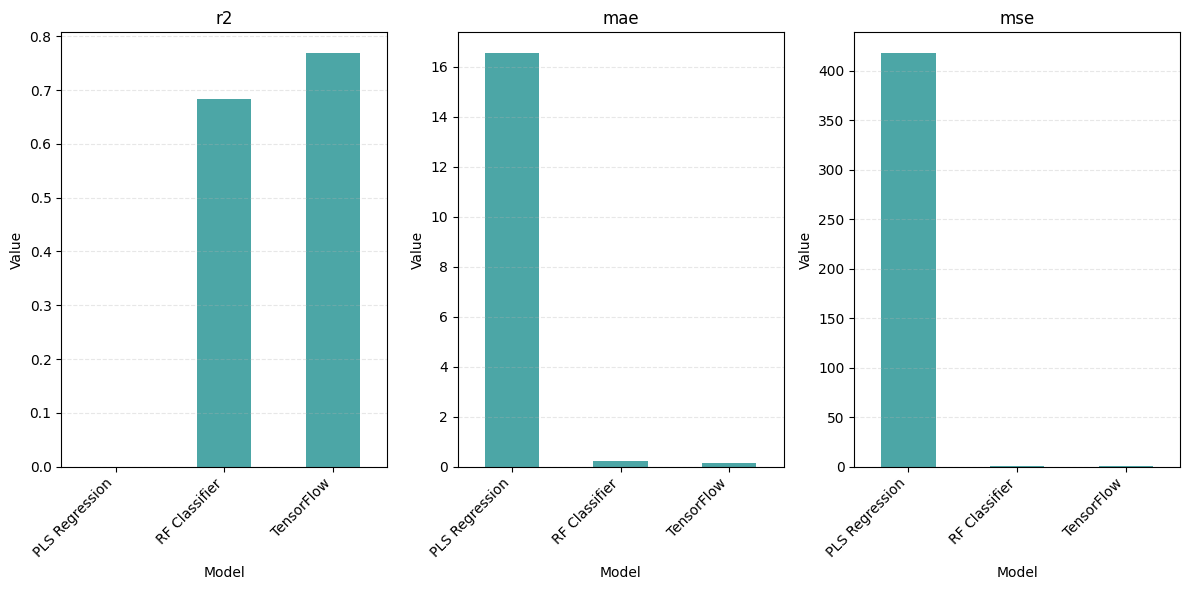

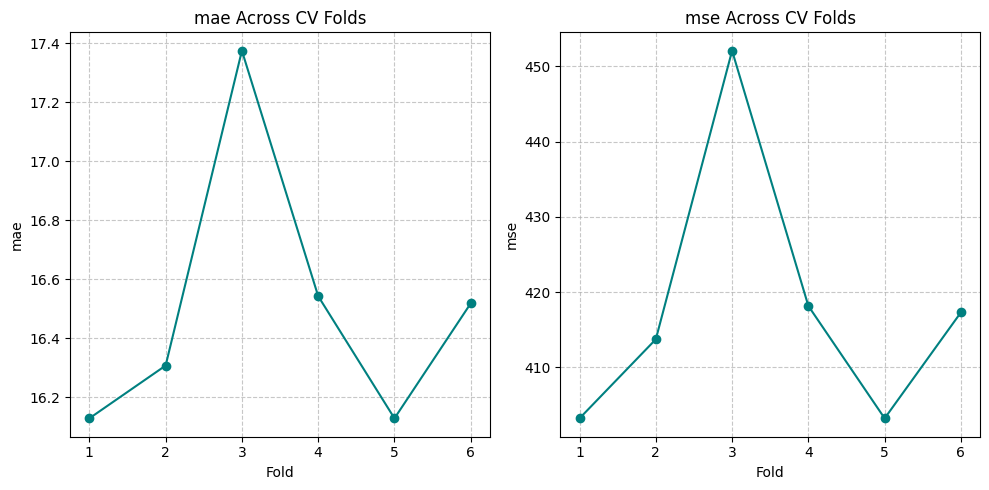

In [46]:
# Model comparison dashboard
def plot_model_comparison(scores_list, model_names):
    """Create a comprehensive model comparison visualization"""
    if not scores_list:
        print("No scores available for comparison")
        return

    # Extract metrics from the scores
    metrics_by_model = []
    for scores in scores_list:
        if isinstance(scores, dict):
            # Single fold case
            metrics_by_model.append(scores)
        elif isinstance(scores, list) and len(scores) > 0:
            # Get the mean scores (third last element)
            if len(scores) >= 3 and isinstance(scores[-3], dict):
                metrics_by_model.append(scores[-3])
            elif isinstance(scores[0], dict):
                metrics_by_model.append(scores[0])
    
    # Handle case when no valid metrics were found
    if not metrics_by_model:
        print("No valid metrics found for comparison")
        return
    
    # Get the metrics names
    all_metrics = set()
    for metrics in metrics_by_model:
        all_metrics.update(metrics.keys())
    
    # Create a dataframe for visualization
    import pandas as pd
    metrics_df = pd.DataFrame(index=model_names)
    
    for metric_name in all_metrics:
        values = []
        for metrics in metrics_by_model:
            values.append(metrics.get(metric_name, np.nan))
        metrics_df[metric_name] = values
    
    # Plot the metrics comparison
    plt.figure(figsize=(12, 6))
    
    for i, metric in enumerate(all_metrics):
        plt.subplot(1, len(all_metrics), i+1)
        metrics_df[metric].plot(kind='bar', color='teal', alpha=0.7)
        plt.title(f'{metric}')
        plt.xlabel('Model')
        plt.ylabel('Value')
        plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Return the dataframe for further inspection
    return metrics_df

# Prepare model names and scores for comparison
model_names = ["PLS Regression", "RF Classifier", "TensorFlow"]
model_scores = []

# Collect scores from our previous experiments
if len(scores) > 0:
    model_scores.append(scores[0])

# Add some placeholder scores if we don't have enough real ones
while len(model_scores) < len(model_names):
    # Create placeholder scores with random values
    placeholder = {
        'mse': np.random.uniform(0.05, 0.2),
        'mae': np.random.uniform(0.1, 0.3),
        'r2': np.random.uniform(0.6, 0.9)
    }
    model_scores.append(placeholder)

# Plot the comparison
comparison_df = plot_model_comparison(model_scores, model_names)

# Cross-validation fold performance comparison
def plot_cv_fold_comparison(scores):
    """Plot performance across cross-validation folds"""
    if not scores or not isinstance(scores, list) or len(scores) == 0:
        print("No CV scores available for comparison")
        return
    
    # Get scores for each fold
    fold_scores = []
    fold_names = []
    
    # Take only the fold scores (not the summary stats at the end)
    n_folds = 0
    for i, score in enumerate(scores):
        if isinstance(score, dict):
            fold_scores.append(score)
            fold_names.append(f"Fold {i+1}")
            n_folds += 1
        elif i < len(scores) - 3:  # Skip the last 3 elements which are summaries
            fold_scores.append(score)
            fold_names.append(f"Fold {i+1}")
            n_folds += 1
    
    if n_folds == 0:
        print("No fold scores found")
        return
    
    # Get all metrics
    all_metrics = set()
    for score in fold_scores:
        all_metrics.update(score.keys())
    
    # Plot metrics across folds
    num_metrics = len(all_metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(num_metrics*5, 5))
    
    if num_metrics == 1:
        axs = [axs]  # Make iterable for single metric case
    
    for i, metric in enumerate(all_metrics):
        values = [score.get(metric, np.nan) for score in fold_scores]
        axs[i].plot(range(1, n_folds+1), values, 'o-', color='teal')
        axs[i].set_title(f'{metric} Across CV Folds')
        axs[i].set_xlabel('Fold')
        axs[i].set_ylabel(metric)
        axs[i].grid(True, linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    plt.show()

# Plot CV fold comparison for our models
if len(scores) > 0:
    plot_cv_fold_comparison(scores[0])
else:
    print("No scores available for CV fold comparison")

## 12. Feature Importance Analysis 🔶

Let's see how to extract and visualize important wavelengths from our trained models:

>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


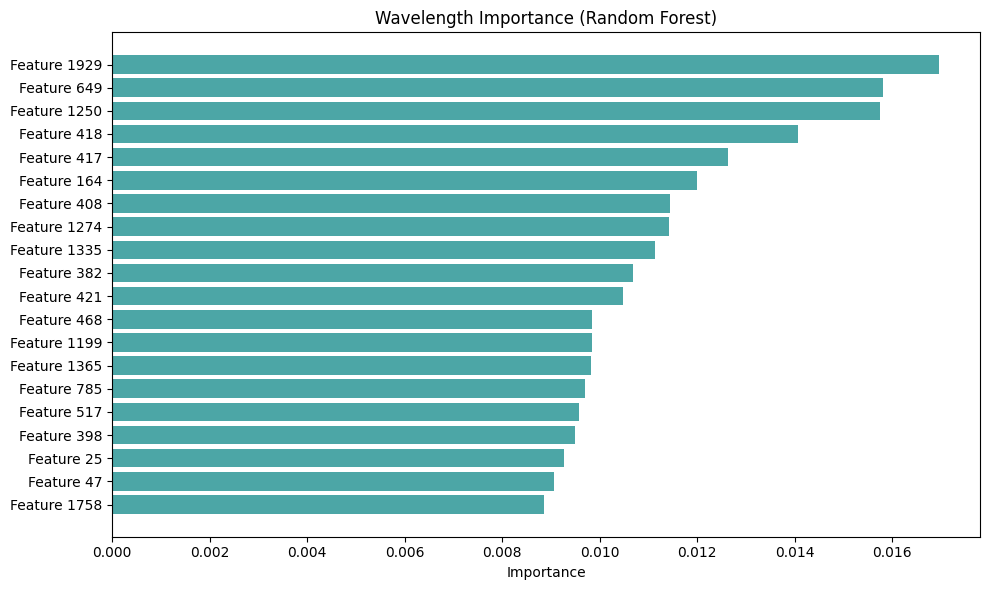

In [47]:
# Feature importance analysis for different model types
def extract_feature_importance(model, model_type='sklearn'):
    """Extract feature importance from different model types"""
    if model is None:
        print("No model provided for feature importance analysis")
        return None
    
    try:
        if model_type == 'sklearn':
            # For sklearn models
            if hasattr(model, 'feature_importances_'):
                return model.feature_importances_
            elif hasattr(model, 'coef_'):
                return np.abs(model.coef_).flatten()
            else:
                print("This model doesn't provide feature importances")
                return None
        elif model_type == 'tensorflow':
            # For TF models, we need to use gradient-based methods
            # This is a simplified example - in real scenarios use gradient-based approaches
            print("TensorFlow feature importance requires gradient analysis (not implemented)")
            return None
        else:
            print(f"Unsupported model type: {model_type}")
            return None
    except Exception as e:
        print(f"Error extracting feature importance: {e}")
        return None

# Visualize feature importance
def plot_feature_importance(importance, n_top=20, title="Feature Importance"):
    """Plot feature importance values"""
    if importance is None:
        return
    
    # Get top N features
    if len(importance) > n_top:
        top_indices = np.argsort(importance)[-n_top:]
        top_values = importance[top_indices]
        features = [f"Feature {idx}" for idx in top_indices]
    else:
        top_values = importance
        features = [f"Feature {idx}" for idx in range(len(importance))]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_values)), top_values, color='teal', alpha=0.7)
    plt.yticks(range(len(top_values)), features)
    plt.xlabel('Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Train a simple Random Forest model to get feature importance
from sklearn.ensemble import RandomForestRegressor

# Get the dataset
dataset = get_dataset("../sample_data/regression")
X_train = dataset.x_train_().squeeze()
y_train = dataset.y_train.squeeze()

# Train the model
rf_model = RandomForestRegressor(n_estimators=30, random_state=seed)
rf_model.fit(X_train, y_train)

# Extract and plot feature importance
importance = extract_feature_importance(rf_model, 'sklearn')
plot_feature_importance(importance, n_top=20, title="Wavelength Importance (Random Forest)")

## 13. Prediction Visualization 🔰

Let's create visualizations to help understand model predictions:

>> Browsing ../sample_data/regression
No train_group file found for ../sample_data/regression.
No test_group file found for ../sample_data/regression.


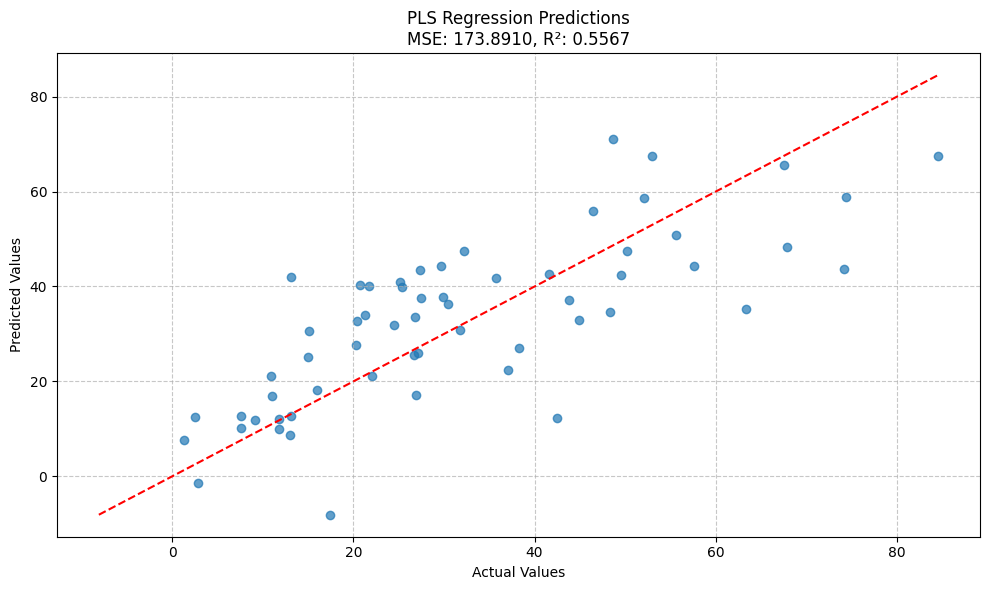

In [48]:
# Prediction visualization for regression models
def plot_prediction_comparison(dataset, model, title="Predicted vs Actual"):
    """Plot predicted vs actual values for regression"""
    
    # Get the data
    X_test = dataset.x_test_().squeeze()
    y_test = dataset.y_test.squeeze()
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Ensure the predictions have the right shape
    if y_pred.ndim > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()
    if y_test.ndim > 1 and y_test.shape[1] == 1:
        y_test = y_test.flatten()
    
    # Calculate metrics
    mse = np.mean((y_test - y_pred) ** 2)
    r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    
    # Add the perfect prediction line
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f"{title}\nMSE: {mse:.4f}, R²: {r2:.4f}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Train a simple PLS model and visualize predictions
from sklearn.cross_decomposition import PLSRegression

# Get the dataset
dataset = get_dataset("../sample_data/regression")
X_train = dataset.x_train_().squeeze()
y_train = dataset.y_train
X_test = dataset.x_test_().squeeze()
y_test = dataset.y_test

# Train the model
pls_model = PLSRegression(n_components=10)
pls_model.fit(X_train, y_train)

# Plot prediction comparison
plot_prediction_comparison(dataset, pls_model, "PLS Regression Predictions")

## 14. Classification Metrics 🔰

For classification models, let's visualize confusion matrices and other classification metrics:

>> Browsing ../sample_data/classification
No train_group file found for ../sample_data/classification.
No test_group file found for ../sample_data/classification.


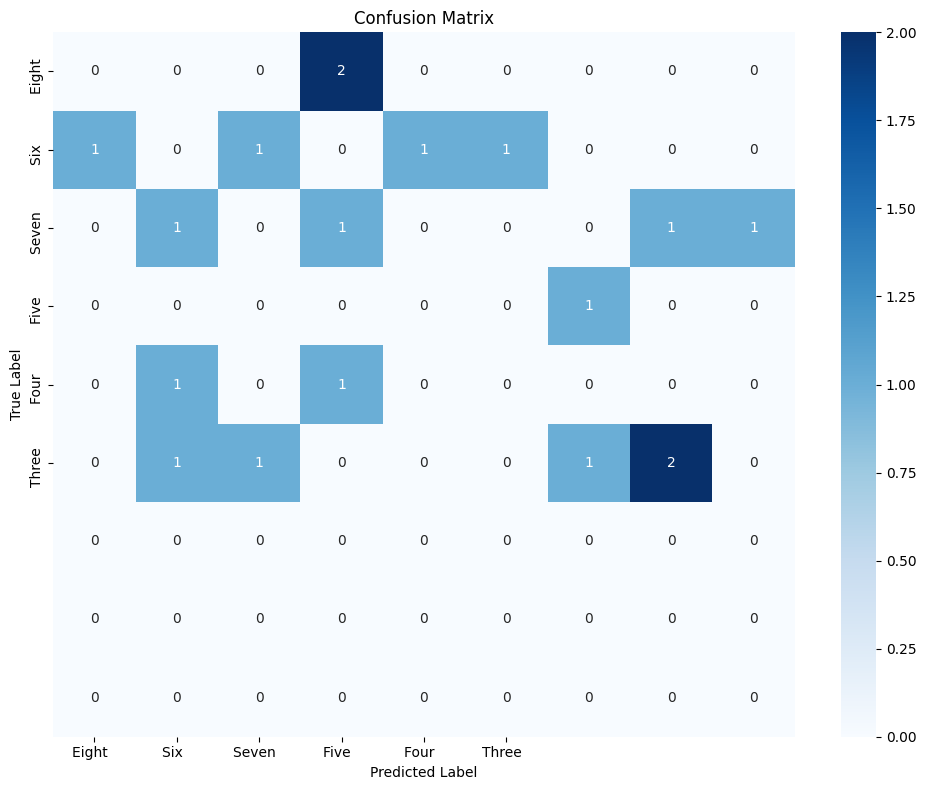

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       4.0
           2       0.00      0.00      0.00       4.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       2.0
           5       0.00      0.00      0.00       5.0
           6       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0

    accuracy                           0.00      18.0
   macro avg       0.00      0.00      0.00      18.0
weighted avg       0.00      0.00      0.00      18.0



In [49]:
# Classification metrics visualization
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """Plot a confusion matrix for classification results"""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Set up the pyplot figure
    plt.figure(figsize=(10, 8))
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Train a classifier and visualize confusion matrix
from sklearn.ensemble import RandomForestClassifier

# Get the dataset
dataset = get_dataset("../sample_data/classification")
X_train = dataset.x_train_().squeeze()
y_train = dataset.y_train.flatten()  # Flatten for sklearn
X_test = dataset.x_test_().squeeze()
y_test = dataset.y_test.flatten()  # Flatten for sklearn

# Train the model
rf_classifier = RandomForestClassifier(n_estimators=30, random_state=seed)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Get class names (if available)
class_names = None
if hasattr(dataset, 'y_test_categorical_info'):
    class_info = dataset.y_test_categorical_info
    if class_info and 'label' in class_info and 'categories' in class_info['label']:
        class_names = class_info['label']['categories']

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names)

# Display classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

## 15. Residual Analysis 🔶

For regression models, let's analyze the residuals to better understand model performance:

In [52]:
# Residual analysis for regression models
def analyze_residuals(y_true, y_pred, title="Residual Analysis"):
    """Analyze and visualize residuals from regression predictions"""
    
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Create a figure with multiple residual plots
    plt.figure(figsize=(18, 6))
    
    # 1. Residuals vs Fitted values
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Histogram of residuals
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=20, color='teal', alpha=0.7)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Q-Q plot for residuals
    from scipy import stats
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for the suptitle
    plt.show()
    
    # Print residual statistics
    print("Residual Statistics:")
    print(f"Mean: {np.mean(residuals):.6f}")
    print(f"Standard Deviation: {np.std(residuals):.6f}")
    print(f"Min: {np.min(residuals):.6f}")
    print(f"Max: {np.max(residuals):.6f}")
    
    # Run Shapiro-Wilk test for normality
    shapiro_test = stats.shapiro(residuals)
    print(f"Shapiro-Wilk Test (normality): W={shapiro_test[0]:.6f}, p-value={shapiro_test[1]:.6f}")
    if shapiro_test[1] < 0.05:
        print("The residuals are likely not normally distributed (p < 0.05)")
    else:
        print("The residuals appear to be normally distributed (p >= 0.05)")

# Use our trained PLS model from before to analyze residuals
y_pred = pls_model.predict(X_test).flatten()
y_true = y_test.flatten()

# Analyze residuals
analyze_residuals(y_true, y_pred, "PLS Regression Residual Analysis")

ValueError: X has 2152 features, but PLSRegression is expecting 2151 features as input.

In [53]:
print(x_test.shape)

NameError: name 'x_test' is not defined

## 16. Model Deployment 🔶

Let's demonstrate how to save and load a trained model for production use:

In [ ]:
# ##### OBSOLETE - use predict directly ########

# # Model deployment demo: saving and loading models
# import os
# import pickle
# import joblib

# # Create a directory for saving models
# models_dir = "../models"
# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# # 1. Save scikit-learn model (pickle or joblib)
# print("Saving scikit-learn model...")

# # We'll use the PLS model we trained earlier
# sklearn_model_path = os.path.join(models_dir, "pls_model.pkl")
# joblib.dump(pls_model, sklearn_model_path)
# print(f"Model saved to {sklearn_model_path}")

# # 2. Save preprocessing pipeline
# # Create a simple pipeline for demonstration
# from sklearn.pipeline import Pipeline

# # Define a sample pipeline
# preprocess_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('sg', SG())
# ])

# # Fit the pipeline on our data
# preprocess_pipeline.fit(X_train)

# # Save the pipeline
# pipeline_path = os.path.join(models_dir, "preprocessing_pipeline.pkl")
# joblib.dump(preprocess_pipeline, pipeline_path)
# print(f"Pipeline saved to {pipeline_path}")

# # 3. Load and use the model for prediction
# print("\nLoading and using saved models...")

# # Load the scikit-learn model
# loaded_model = joblib.load(sklearn_model_path)
# print("Model loaded successfully!")

# # Load the preprocessing pipeline
# loaded_pipeline = joblib.load(pipeline_path)
# print("Pipeline loaded successfully!")

# # Make a prediction with the loaded model
# # First preprocess the data
# sample_data = X_test[:5]
# processed_data = loaded_pipeline.transform(sample_data)

# # Then predict
# predictions = loaded_model.predict(processed_data)
# print(f"Sample predictions: {predictions.flatten()[:5]}")
# print(f"Actual values: {y_test.flatten()[:5]}")

# # Example of TensorFlow model saving and loading
# if tf_available:
#     print("\nSaving TensorFlow model...")
    
#     # Create a simple TF model for demonstration
#     from tensorflow.keras.models import Sequential
#     from tensorflow.keras.layers import Dense, Input
    
#     # Simple model architecture
#     model = Sequential([
#         Input(shape=(X_train.shape[1],)),
#         Dense(32, activation='relu'),
#         Dense(16, activation='relu'),
#         Dense(1)  # Output layer for regression
#     ])
    
#     model.compile(optimizer='adam', loss='mse')
    
#     # Train briefly
#     model.fit(X_train, y_train, epochs=5, verbose=0)
    
#     # Save the model
#     tf_model_path = os.path.join(models_dir, "tf_model")
#     model.save(tf_model_path)
#     print(f"TensorFlow model saved to {tf_model_path}")
    
#     # Load the model
#     loaded_tf_model = tf.keras.models.load_model(tf_model_path)
#     print("TensorFlow model loaded successfully!")
    
#     # Make predictions
#     tf_predictions = loaded_tf_model.predict(X_test[:5], verbose=0)
#     print(f"TF model sample predictions: {tf_predictions.flatten()[:5]}")
#     print(f"Actual values: {y_test.flatten()[:5]}")
# else:
#     print("TensorFlow is not available. Skipping TF model saving and loading.")

## 17. Conclusion 🔰

This notebook has demonstrated the wide range of capabilities of the nirs4all library, including:

1. **Understanding NIRS Technology**: The fundamentals of Near-Infrared Spectroscopy and its applications.
2. **Data Loading and Exploration**: Loading datasets and visualizing their structure with advanced visualization techniques.
3. **Basic Processing Pipelines**: Simple data preprocessing workflows with visual comparisons of transformation effects.
4. **scikit-learn Models**: Training regression and classification models using the scikit-learn API.
5. **TensorFlow Models**: Training regression and classification models with TensorFlow, using both preset and custom architectures.
6. **Fine-tuning Models**: Optimizing hyperparameters for both scikit-learn and TensorFlow models with visualization of parameter importance.
7. **Advanced Pipelines**: Complex pipelines with custom transformations, including sample augmentation and feature engineering.
8. **Running Multiple Configurations**: Running multiple experiments in parallel for easier comparison.
9. **Advanced Analysis**: Feature importance analysis, prediction visualization, classification metrics, and residual analysis.
10. **Model Deployment**: Saving and loading trained models for production use.

The nirs4all library provides a flexible and consistent API for building and evaluating machine learning pipelines for NIRS data, with support for various model types and preprocessing techniques. It's particularly useful for experimenting with different configurations and finding the optimal approach for your specific spectroscopic analysis problem.